In [6]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# 1. Import data and functions

In [17]:
data <- read.csv("table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN")); head(data)

ID Treatment Cal_cum  LV_TAG lipidosis_area_pct Fat_mass subq_wt epi_wat
1 1  LFD       1425.870 367.77 17.596             11.152   0.40    1.80   
2 2  LFD       1241.231 400.53  0.696              7.357   0.72    1.34   
3 3  LFD       1298.180 379.47 17.311             10.517   0.89    2.08   
4 4  LFD       1812.026 332.67 16.353             12.781   0.78    2.13   
5 5  LFD       1373.638 408.33  5.164              6.385   0.26    0.97   
6 6  LFD       1448.174 454.35 22.362             11.460   0.99    2.07   
  mesenteric_wt plasma_TAG vars
1 0.33          38.547     LFD 
2 0.48          53.408     LFD 
3 0.94          68.087     LFD 
4 0.54          37.492     LFD 
5 0.32          46.053     LFD 
6 0.60          45.932     LFD

In [26]:
txn <- data %>% filter(vars == "HFD+TXN"); hfd <- data %>% filter(vars == "HFD");
lxn <- data %>% filter(vars == "HFD+LXN"); hxn <- data %>% filter(vars == "HFD+HXN");
lfd <- data %>% filter(vars == "LFD")

In [61]:
.ci <-
function(x,conf.level=0.95) {
  tri <- sort(na.omit(x))
  if (any(!is.finite(tri))) {tri <- tri[-which(!is.finite(tri))]}
  repet <- length(tri)
  int <- (1-conf.level)/2
  if(repet*int<1) {
    int.inf <- ceiling(repet*int)
  } else {
    int.inf <- floor(repet*int)
  }
  int.sup <- ceiling(repet*(1-int))
  result <- c("Inf"=tri[int.inf],"Sup"=tri[int.sup])
  return(result)
}

#ref: https://rdrr.io/cran/RVAideMemoire/src/R/ci.R

spearman.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="spearman")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="spearman")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Spearman's rank correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}
#ref: https://rdrr.io/cran/RVAideMemoire/src/R/spearman.ci.R

pearson.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="pearson")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="pearson")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Pearson correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

#plots
ggplotRegression <- function (fit, vars) {

require(ggplot2)

ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
  geom_point(aes(color = vars), size = 5) +
  stat_smooth(method = "lm", col = "red", geom = "smooth") +
  labs(title = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 4))) +
    theme(axis.title = element_text(size= 20, face = 'bold'),
         axis.text = element_text(size = 18))
}


ggplotRegression2 <- function (fit) {

require(ggplot2)

ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
  geom_point(size = 5) +
  stat_smooth(method = "lm", col = "red", geom = "smooth") +
  labs(subtitle = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 4))) +
    theme(axis.title = element_text(size= 20, face = 'bold'),
         axis.text = element_text(size = 18))
}
#https://sejohnston.com/2012/08/09/a-quick-and-easy-function-to-plot-lm-results-in-r/

theme_set(theme_bw())

# 2. steatosis score and total caloric intake

## 2.1 Correlation

### 2.1.1 overall

#### Spearman

In [19]:
data %>%
    summarise(r = spearman.ci(lipidosis_area_pct, Cal_cum)$estimate,
             pvalue = cor.test(lipidosis_area_pct, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(lipidosis_area_pct, Cal_cum)$conf.int[1],
             upper = spearman.ci(lipidosis_area_pct, Cal_cum)$conf.int[2])

r         pvalue     lower      upper    
1 0.3292227 0.01120889 0.05449759 0.5766346

#### Pearson

In [20]:
data %>%
    summarise(r = pearson.ci(lipidosis_area_pct, Cal_cum)$estimate,
             pvalue = cor.test(lipidosis_area_pct, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(lipidosis_area_pct, Cal_cum)$conf.int[1],
             upper = pearson.ci(lipidosis_area_pct, Cal_cum)$conf.int[2])

r         pvalue     lower        upper    
1 0.2861182 0.02803163 -0.001130088 0.5391974

#### Plot

In [21]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)

`geom_smooth()` using formula 'y ~ x'



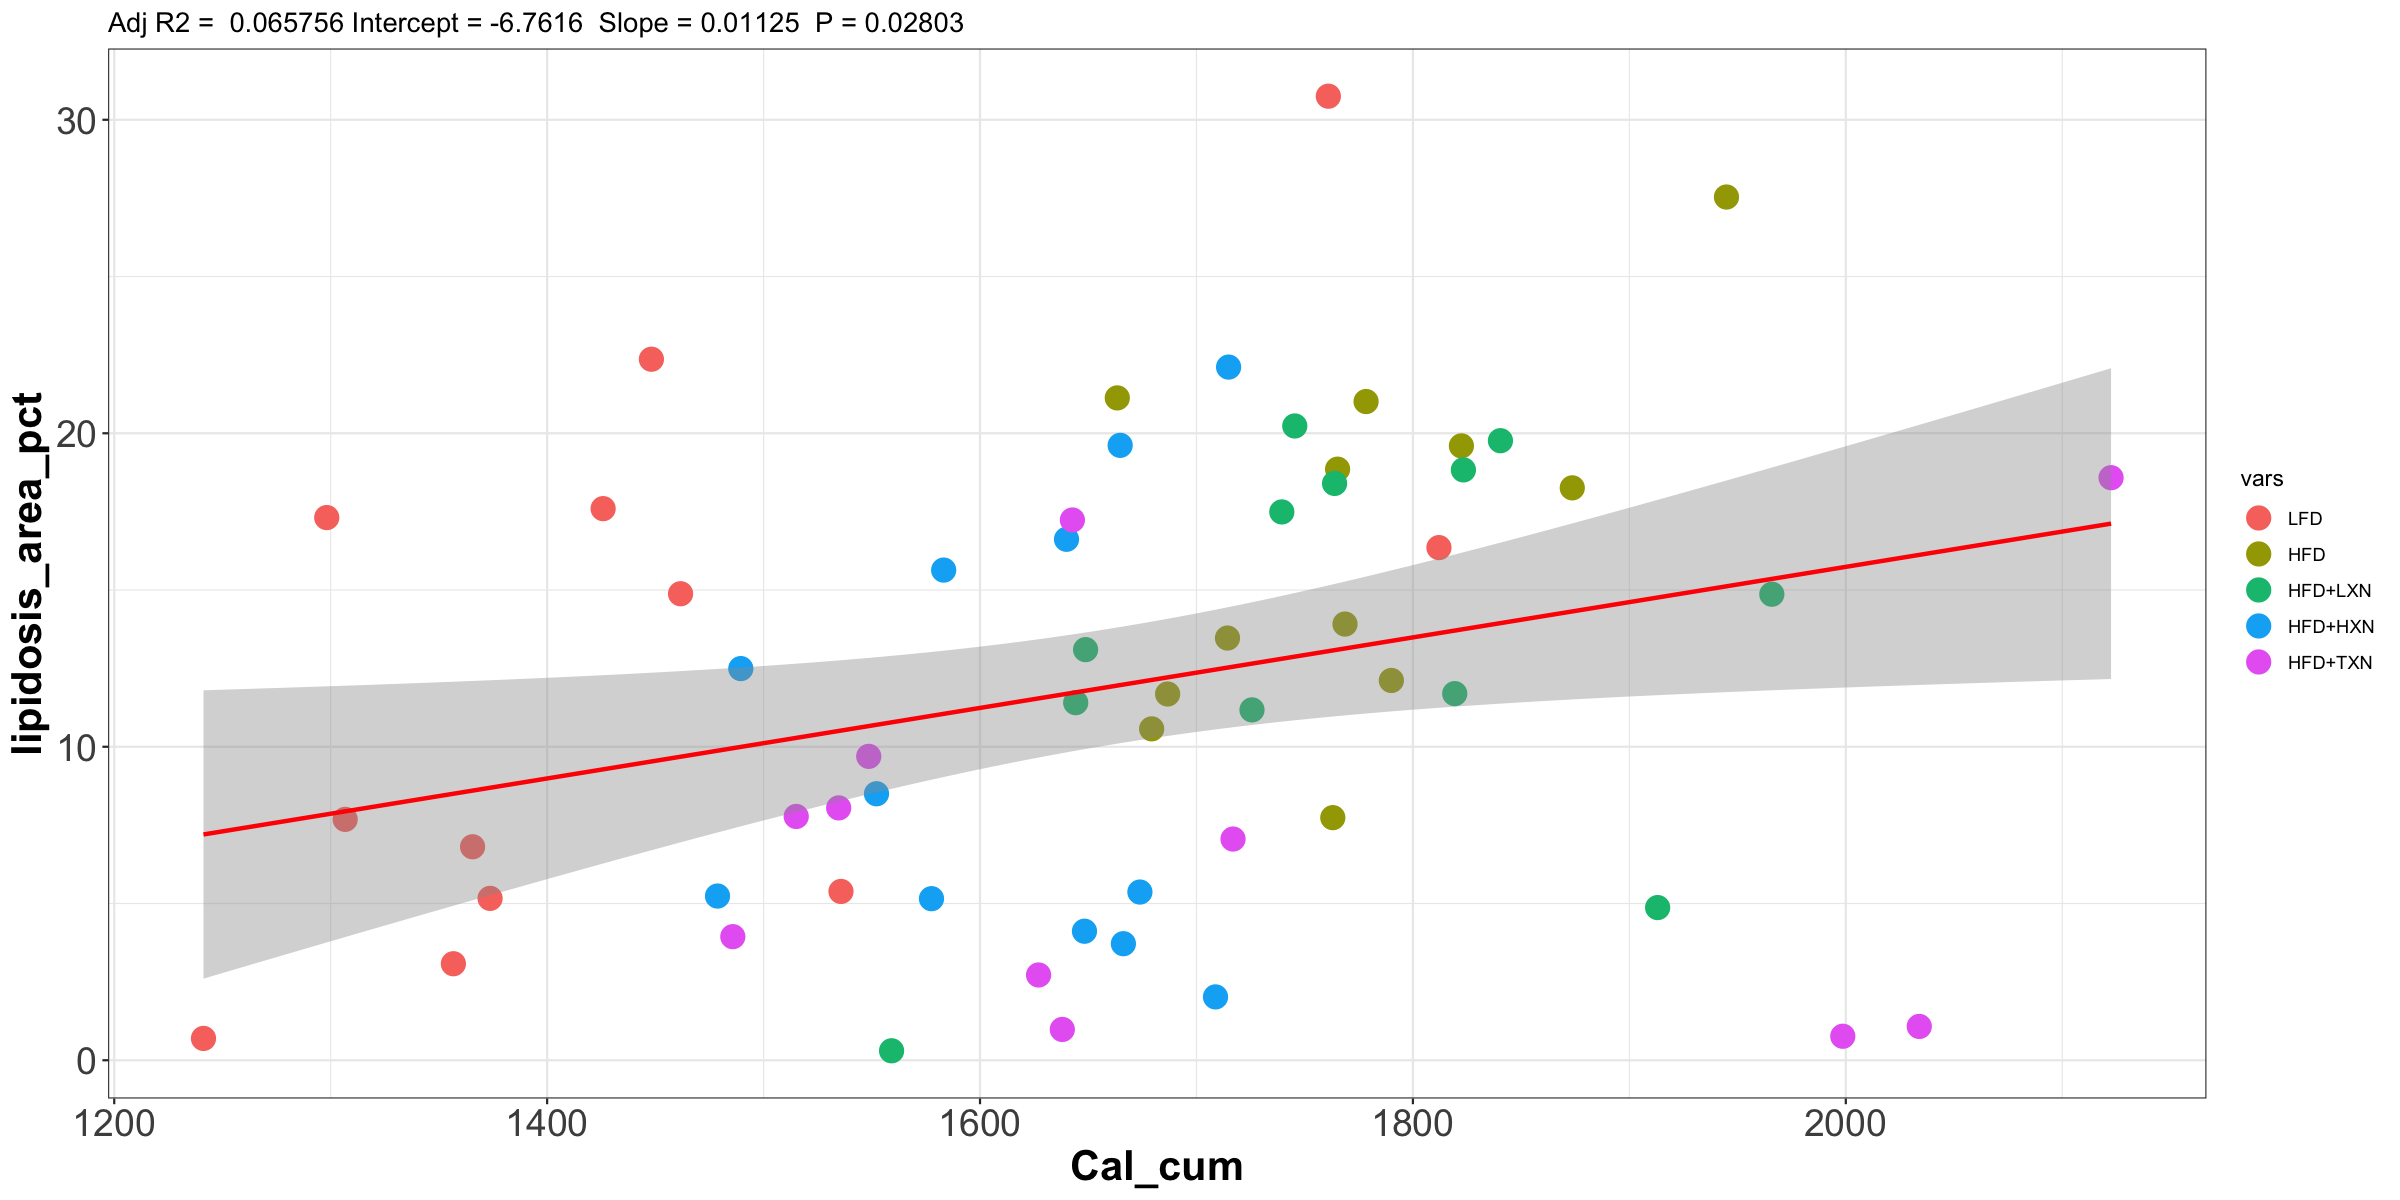

In [22]:
ggplotRegression(lm(lipidosis_area_pct ~ Cal_cum, data = data), data$vars)

### 2.1.2 by group

#### Spearman

In [23]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(lipidosis_area_pct, Cal_cum)$estimate,
             pvalue = cor.test(lipidosis_area_pct, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(lipidosis_area_pct, Cal_cum)$conf.int[1],
             upper = spearman.ci(lipidosis_area_pct, Cal_cum)$conf.int[2])

vars    r           pvalue    lower      upper    
1 LFD      0.48951049 0.1096325 -0.1714286 0.8905109
2 HFD      0.41258741 0.1844807 -0.3136531 0.9040590
3 HFD+LXN  0.37062937 0.2367322 -0.2996390 0.8916968
4 HFD+HXN -0.01398601 0.9736939 -0.7391304 0.6845878
5 HFD+TXN -0.06363636 0.8601035 -0.7307692 0.6338028

#### Pearson

In [24]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(lipidosis_area_pct, Cal_cum)$estimate,
             pvalue = cor.test(lipidosis_area_pct, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(lipidosis_area_pct, Cal_cum)$conf.int[1],
             upper = pearson.ci(lipidosis_area_pct, Cal_cum)$conf.int[2])

vars    r          pvalue     lower       upper    
1 LFD     0.61102758 0.03479538  0.09157755 0.8920734
2 HFD     0.56652082 0.05479645 -0.17489335 0.8976829
3 HFD+LXN 0.32544772 0.30194969 -0.51966612 0.8703843
4 HFD+HXN 0.12279035 0.70381359 -0.60026502 0.6561844
5 HFD+TXN 0.07569276 0.82494431 -0.74320916 0.6979971

## 2.2 Regression

In [25]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(lipidosis_area_pct ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope       err         CI.lower      CI.upper   r.squared  
1 LFD     0.031012601 0.012705398  0.0027032101 0.05932199 0.373354699
2 HFD     0.038992289 0.017935565 -0.0009706402 0.07895522 0.320945840
3 HFD+LXN 0.017305479 0.015899794 -0.0181214697 0.05273243 0.105916217
4 HFD+HXN 0.010690598 0.027323656 -0.0501903012 0.07157150 0.015077469
5 HFD+TXN 0.002061449 0.009052097 -0.0184158170 0.02253871 0.005729394
  adj.r.squared p.value   
1  0.31069017   0.03479538
2  0.25304042   0.05479645
3  0.01650784   0.30194969
4 -0.08341478   0.70381359
5 -0.10474512   0.82494431

#### Plot

In [64]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_steatosis <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_steatosis <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_steatosis <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_steatosis <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_steatosis <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_steatosis | hfd_steatosis) / (lxn_steatosis |hxn_steatosis | txn_steatosis) + 
plot_annotation(title = 'Steatosis vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

# 3 liver TAG and total caloric intake

## 3.1 Correlation

### 3.1.1 overall

#### Spearman

In [67]:
data %>%
    summarise(r = spearman.ci(LV_TAG, Cal_cum)$estimate,
             pvalue = cor.test(LV_TAG, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(LV_TAG, Cal_cum)$conf.int[1],
             upper = spearman.ci(LV_TAG, Cal_cum)$conf.int[2])

Warning message in cor.test.default(LV_TAG, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


r         pvalue       lower     upper    
1 0.4502111 0.0003465167 0.2250238 0.6393011

#### Pearson

In [68]:
data %>%
    summarise(r = pearson.ci(LV_TAG, Cal_cum)$estimate,
             pvalue = cor.test(LV_TAG, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(LV_TAG, Cal_cum)$conf.int[1],
             upper = pearson.ci(LV_TAG, Cal_cum)$conf.int[2])

r         pvalue     lower     upper    
1 0.3565483 0.00557408 0.1824652 0.5343191

#### Plot

In [69]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)

`geom_smooth()` using formula 'y ~ x'



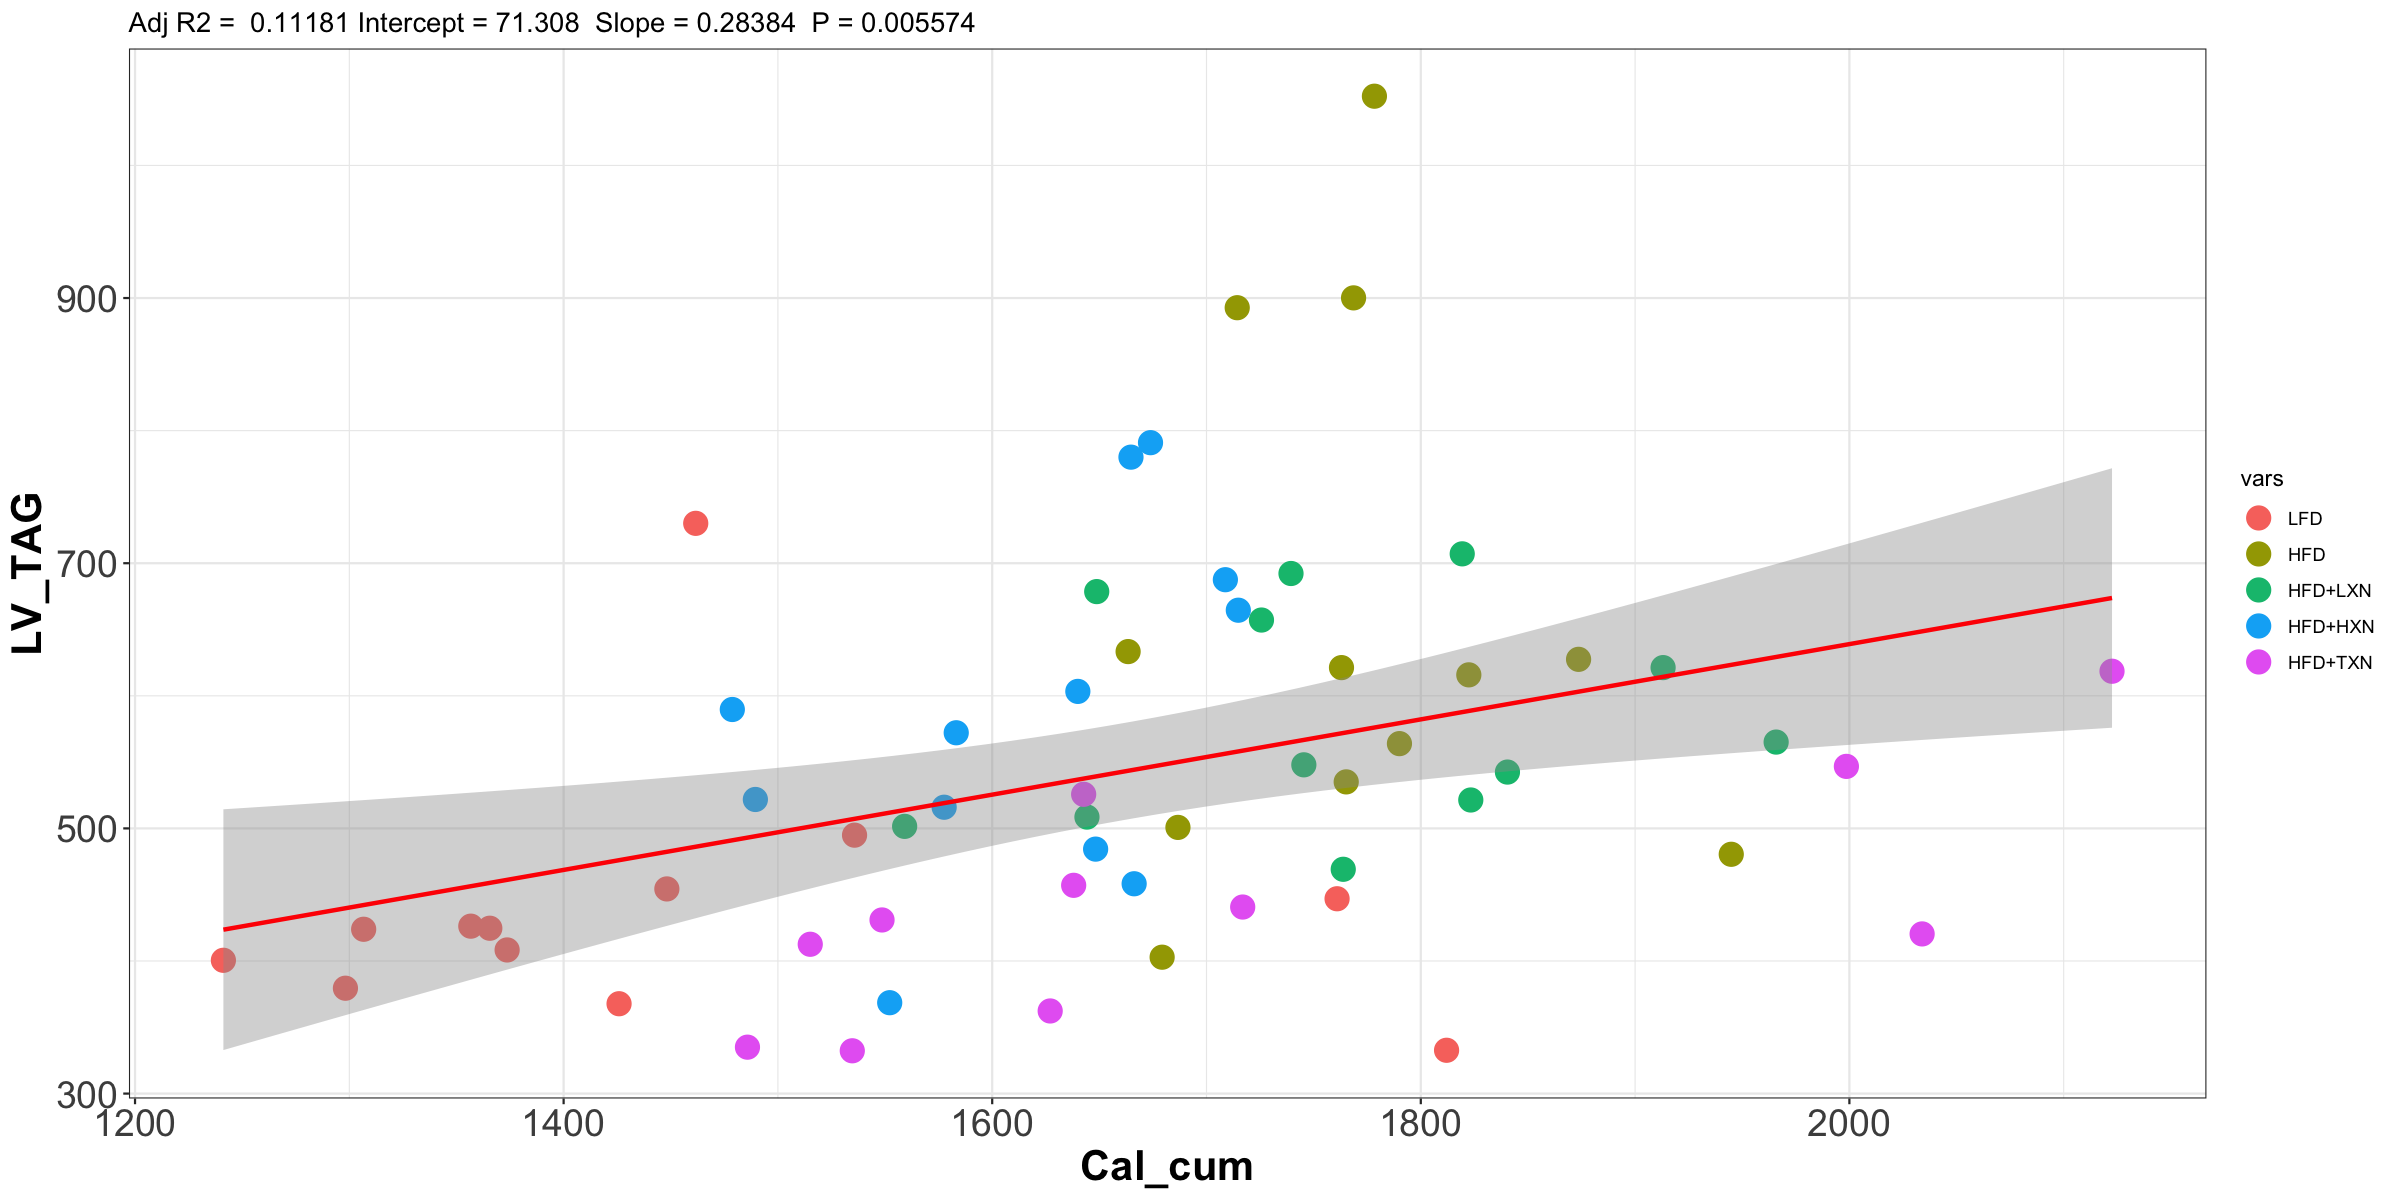

In [70]:
ggplotRegression(lm(LV_TAG ~ Cal_cum, data = data), data$vars)

### 3.1.2 by group

#### Spearman

In [71]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(LV_TAG, Cal_cum)$estimate,
             pvalue = cor.test(LV_TAG, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(LV_TAG, Cal_cum)$conf.int[1],
             upper = spearman.ci(LV_TAG, Cal_cum)$conf.int[2])

vars    r          pvalue      lower      upper    
1 LFD     0.28671329 0.366408456 -0.4963504 0.8510638
2 HFD     0.01398601 0.973693904 -0.6344086 0.7777778
3 HFD+LXN 0.13286713 0.683365534 -0.5744681 0.6750903
4 HFD+HXN 0.50349650 0.098751570 -0.2269504 0.8351254
5 HFD+TXN 0.76363636 0.009215987  0.3148148 0.9718310

#### Pearson

In [72]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(LV_TAG, Cal_cum)$estimate,
             pvalue = cor.test(LV_TAG, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(LV_TAG, Cal_cum)$conf.int[1],
             upper = pearson.ci(LV_TAG, Cal_cum)$conf.int[2])

vars    r           pvalue     lower       upper    
1 LFD     -0.01103420 0.97284993 -0.62504827 0.6739908
2 HFD     -0.04894032 0.87994473 -0.62537582 0.4871126
3 HFD+LXN  0.11295590 0.72669757 -0.51674138 0.5685888
4 HFD+HXN  0.48138685 0.11307587  0.07361379 0.7721094
5 HFD+TXN  0.71600490 0.01320455  0.20524769 0.9496316

## 3.2 Regression

In [73]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(LV_TAG ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope        err        CI.lower    CI.upper  r.squared   
1 LFD     -0.006263476 0.17949327 -0.40619941 0.3936725 0.0001217535
2 HFD     -0.116226746 0.75009895 -1.78755136 1.5550979 0.0023951548
3 HFD+LXN  0.080865205 0.22493878 -0.42032963 0.5820600 0.0127590363
4 HFD+HXN  0.772553511 0.44482619 -0.21858101 1.7636880 0.2317333004
5 HFD+TXN  0.281986565 0.09164438  0.07467257 0.4893006 0.5126630187
  adj.r.squared p.value   
1 -0.09986607   0.97284993
2 -0.09736533   0.87994473
3 -0.08596506   0.72669757
4  0.15490663   0.11307587
5  0.45851447   0.01320455

#### Plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



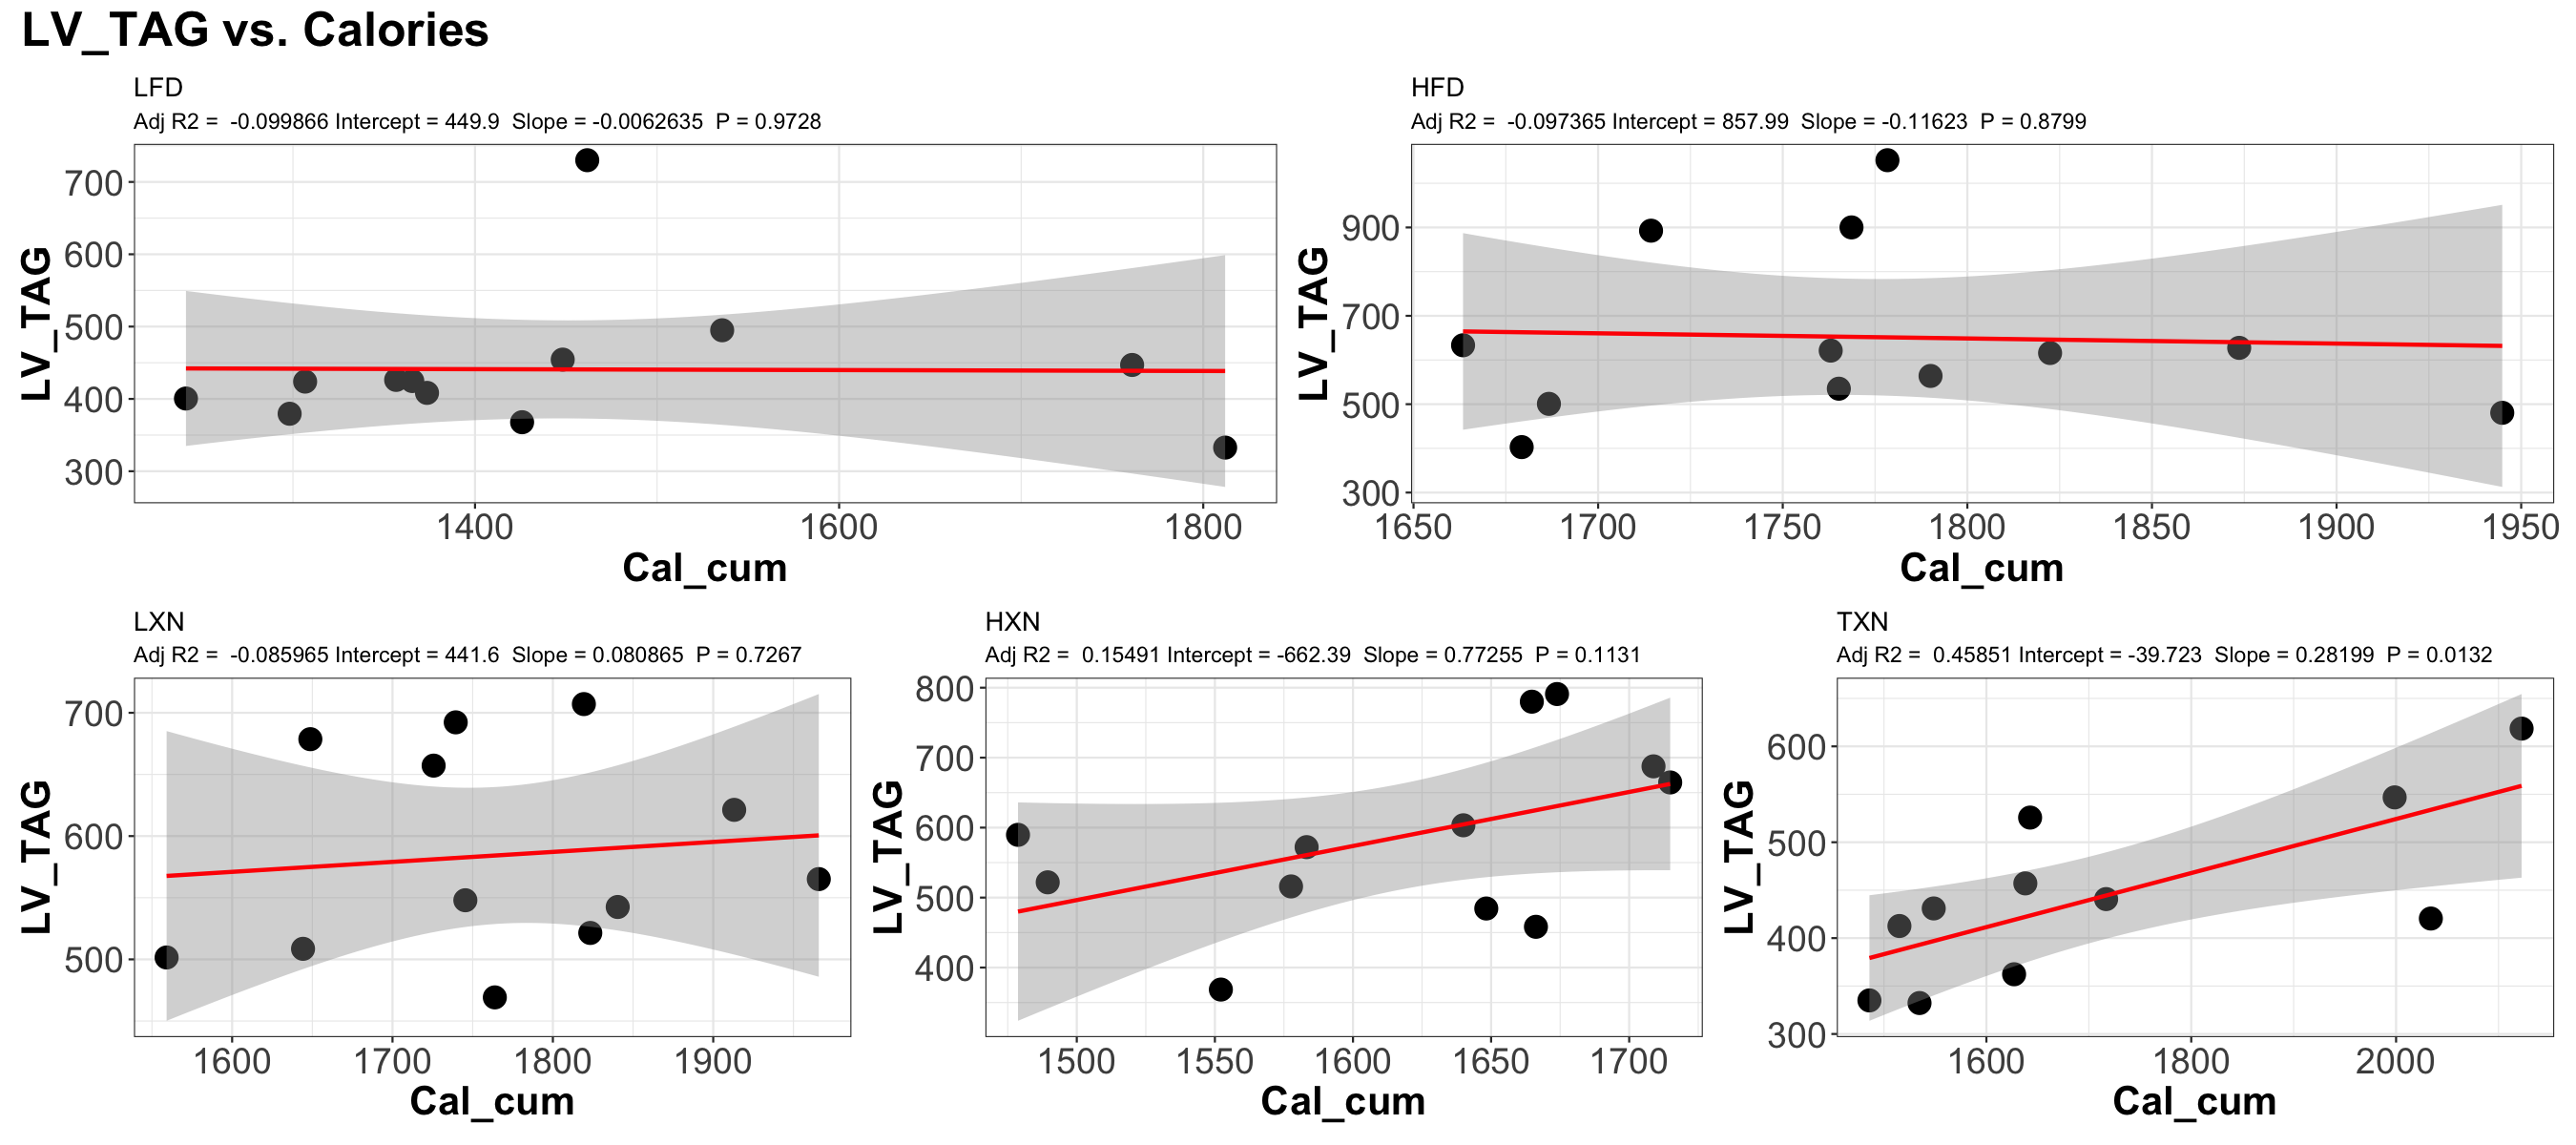

In [74]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_LV_TAG <- ggplotRegression2(lm(LV_TAG ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_LV_TAG <- ggplotRegression2(lm(LV_TAG ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_LV_TAG <- ggplotRegression2(lm(LV_TAG ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_LV_TAG <- ggplotRegression2(lm(LV_TAG ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_LV_TAG <- ggplotRegression2(lm(LV_TAG ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_LV_TAG | hfd_LV_TAG) / (lxn_LV_TAG |hxn_LV_TAG | txn_LV_TAG) + 
plot_annotation(title = 'LV_TAG vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

# 4. total fat mass (by dexa) and total caloric intake

## 4.1 Correlation

### 4.1.1 overall

#### Spearman

In [75]:
data %>%
    summarise(r = spearman.ci(Fat_mass, Cal_cum)$estimate,
             pvalue = cor.test(Fat_mass, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(Fat_mass, Cal_cum)$conf.int[1],
             upper = spearman.ci(Fat_mass, Cal_cum)$conf.int[2])

r         pvalue       lower     upper    
1 0.4998831 6.962802e-05 0.2307512 0.7119616

#### Pearson

In [76]:
data %>%
    summarise(r = pearson.ci(Fat_mass, Cal_cum)$estimate,
             pvalue = cor.test(Fat_mass, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(Fat_mass, Cal_cum)$conf.int[1],
             upper = pearson.ci(Fat_mass, Cal_cum)$conf.int[2])

r         pvalue       lower     upper    
1 0.5228768 2.151917e-05 0.2338535 0.7550492

#### Plot

`geom_smooth()` using formula 'y ~ x'



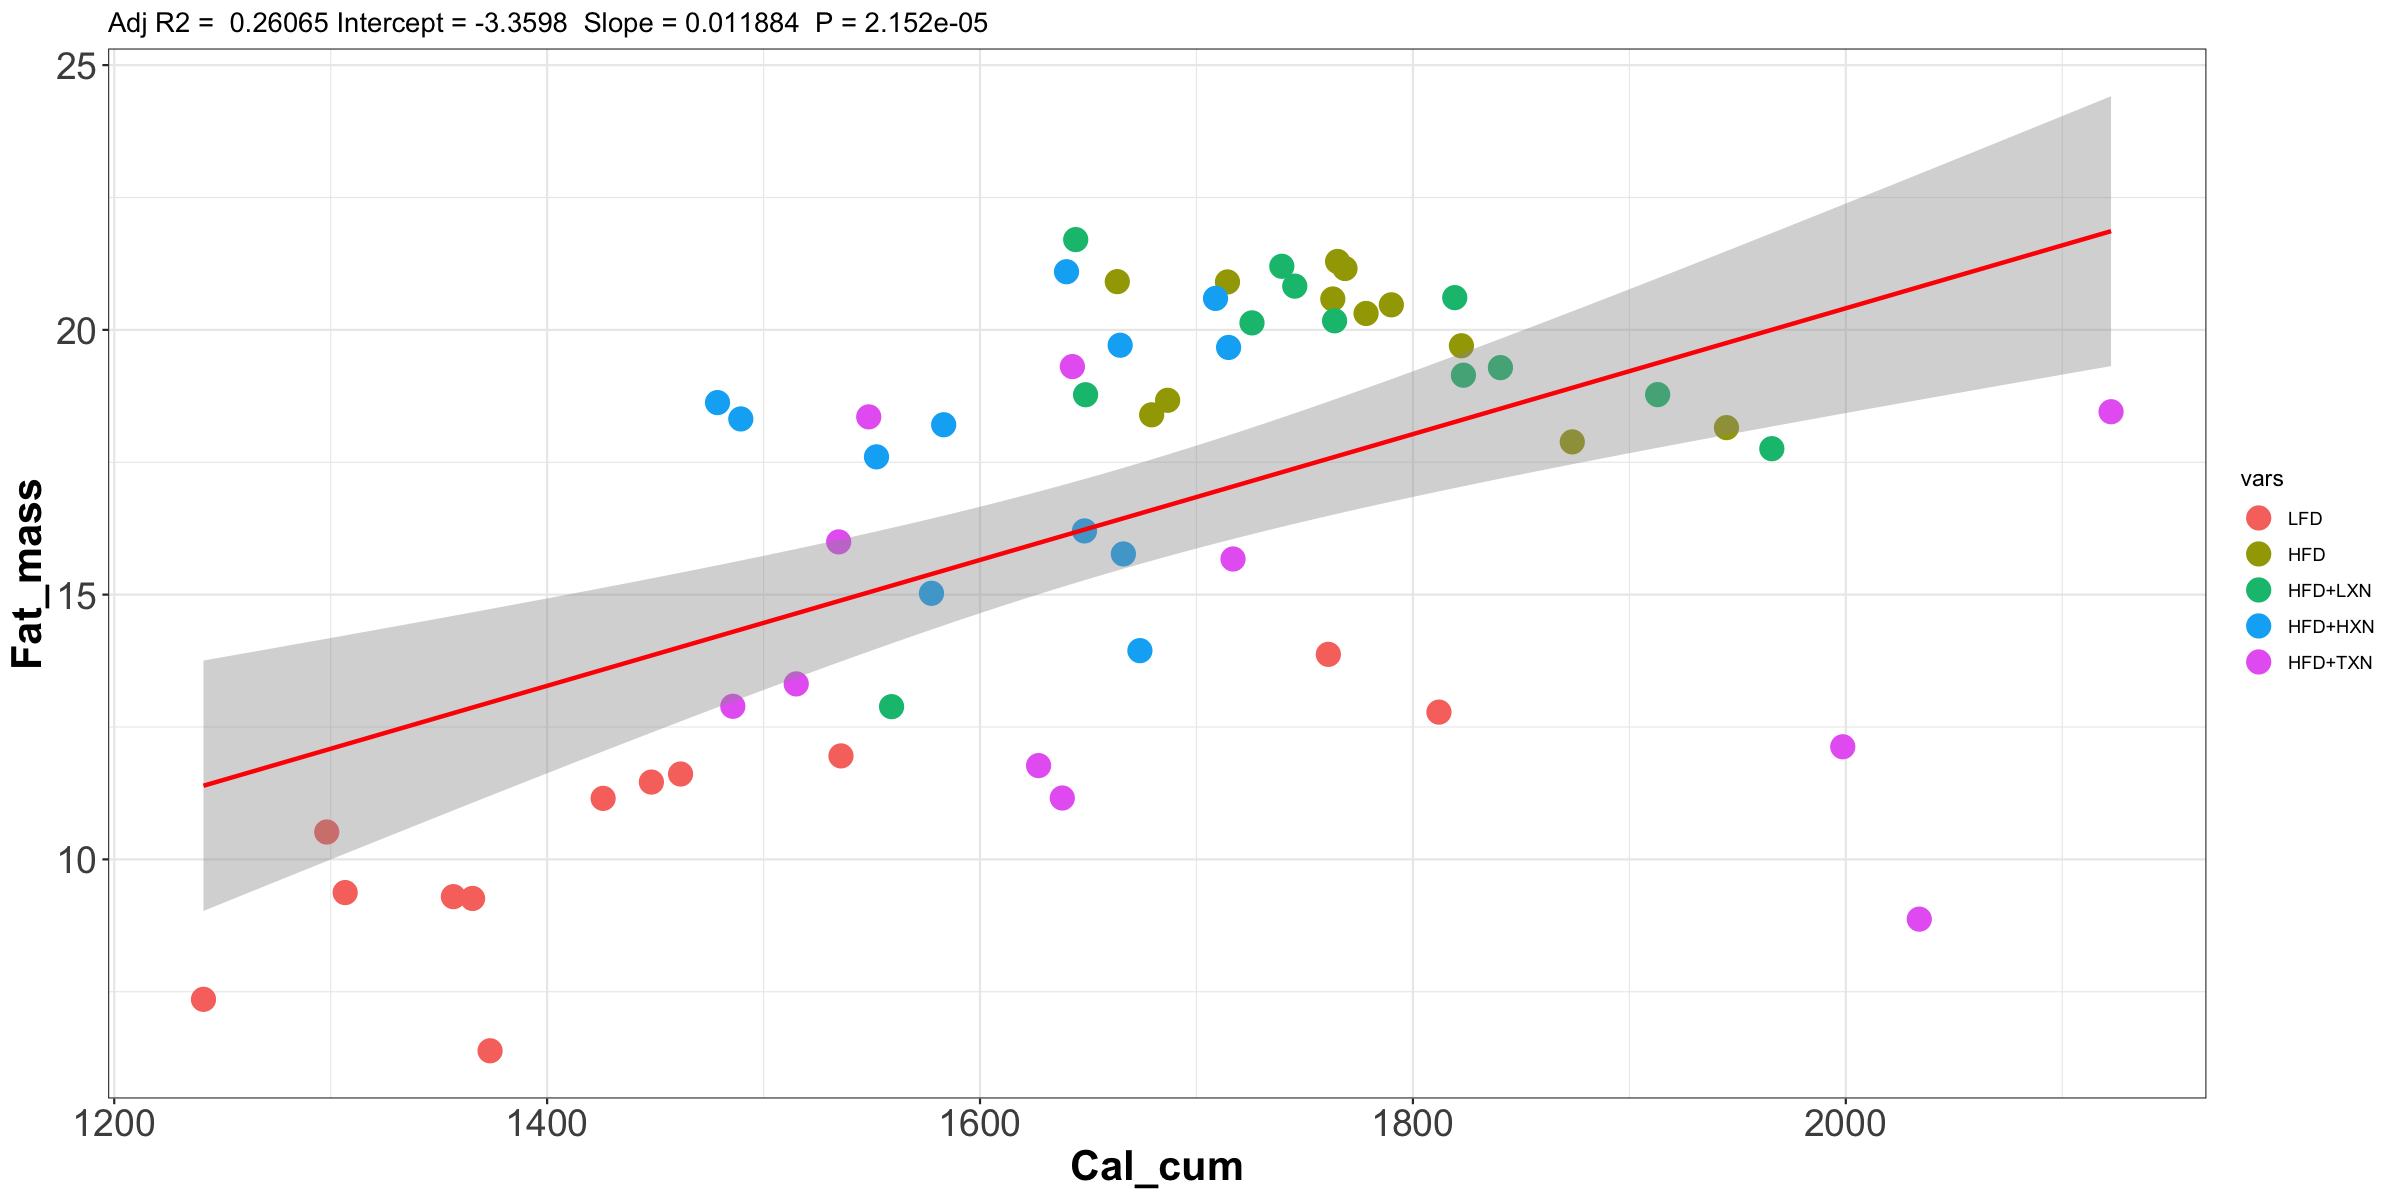

In [77]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)
ggplotRegression(lm(Fat_mass ~ Cal_cum, data = data), data$vars)

### 4.1.2 by group

#### Spearman

In [78]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(Fat_mass, Cal_cum)$estimate,
             pvalue = cor.test(Fat_mass, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(Fat_mass, Cal_cum)$conf.int[1],
             upper = spearman.ci(Fat_mass, Cal_cum)$conf.int[2])

vars    r           pvalue      lower      upper    
1 LFD      0.81818182 0.002027199  0.3191489 0.9926199
2 HFD     -0.40559441 0.192612184 -0.8857143 0.3207547
3 HFD+LXN -0.20279720 0.528100237 -0.9552239 0.5090253
4 HFD+HXN  0.09790210 0.766288456 -0.5869565 0.5812274
5 HFD+TXN -0.02727273 0.945983670 -0.7142857 0.6037736

#### Pearson

In [79]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(Fat_mass, Cal_cum)$estimate,
             pvalue = cor.test(Fat_mass, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(Fat_mass, Cal_cum)$conf.int[1],
             upper = pearson.ci(Fat_mass, Cal_cum)$conf.int[2])

vars    r           pvalue      lower      upper    
1 LFD      0.78692421 0.002388507  0.5145936 0.9472325
2 HFD     -0.39333162 0.205891479 -0.9072881 0.5263393
3 HFD+LXN  0.22140863 0.489206435 -0.9500694 0.7721055
4 HFD+HXN  0.08363929 0.796076756 -0.4471470 0.5671315
5 HFD+TXN -0.12966453 0.703961099 -0.7597880 0.5555876

## 4.2 Regression

In [80]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(Fat_mass ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope        err         CI.lower     CI.upper    r.squared 
1 LFD      0.009689779 0.002402709  0.004336211 0.015043347 0.61924972
2 HFD     -0.006027265 0.004455171 -0.015954004 0.003899474 0.15470976
3 HFD+LXN  0.004430467 0.006170782 -0.009318893 0.018179826 0.04902178
4 HFD+HXN  0.002373123 0.008940987 -0.017548638 0.022294884 0.00699553
5 HFD+TXN -0.001944626 0.004956918 -0.013157953 0.009268701 0.01681289
  adj.r.squared p.value    
1  0.58117469   0.002388507
2  0.07018074   0.205891479
3 -0.04607604   0.489206435
4 -0.09230492   0.796076756
5 -0.09243012   0.703961099

#### Plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



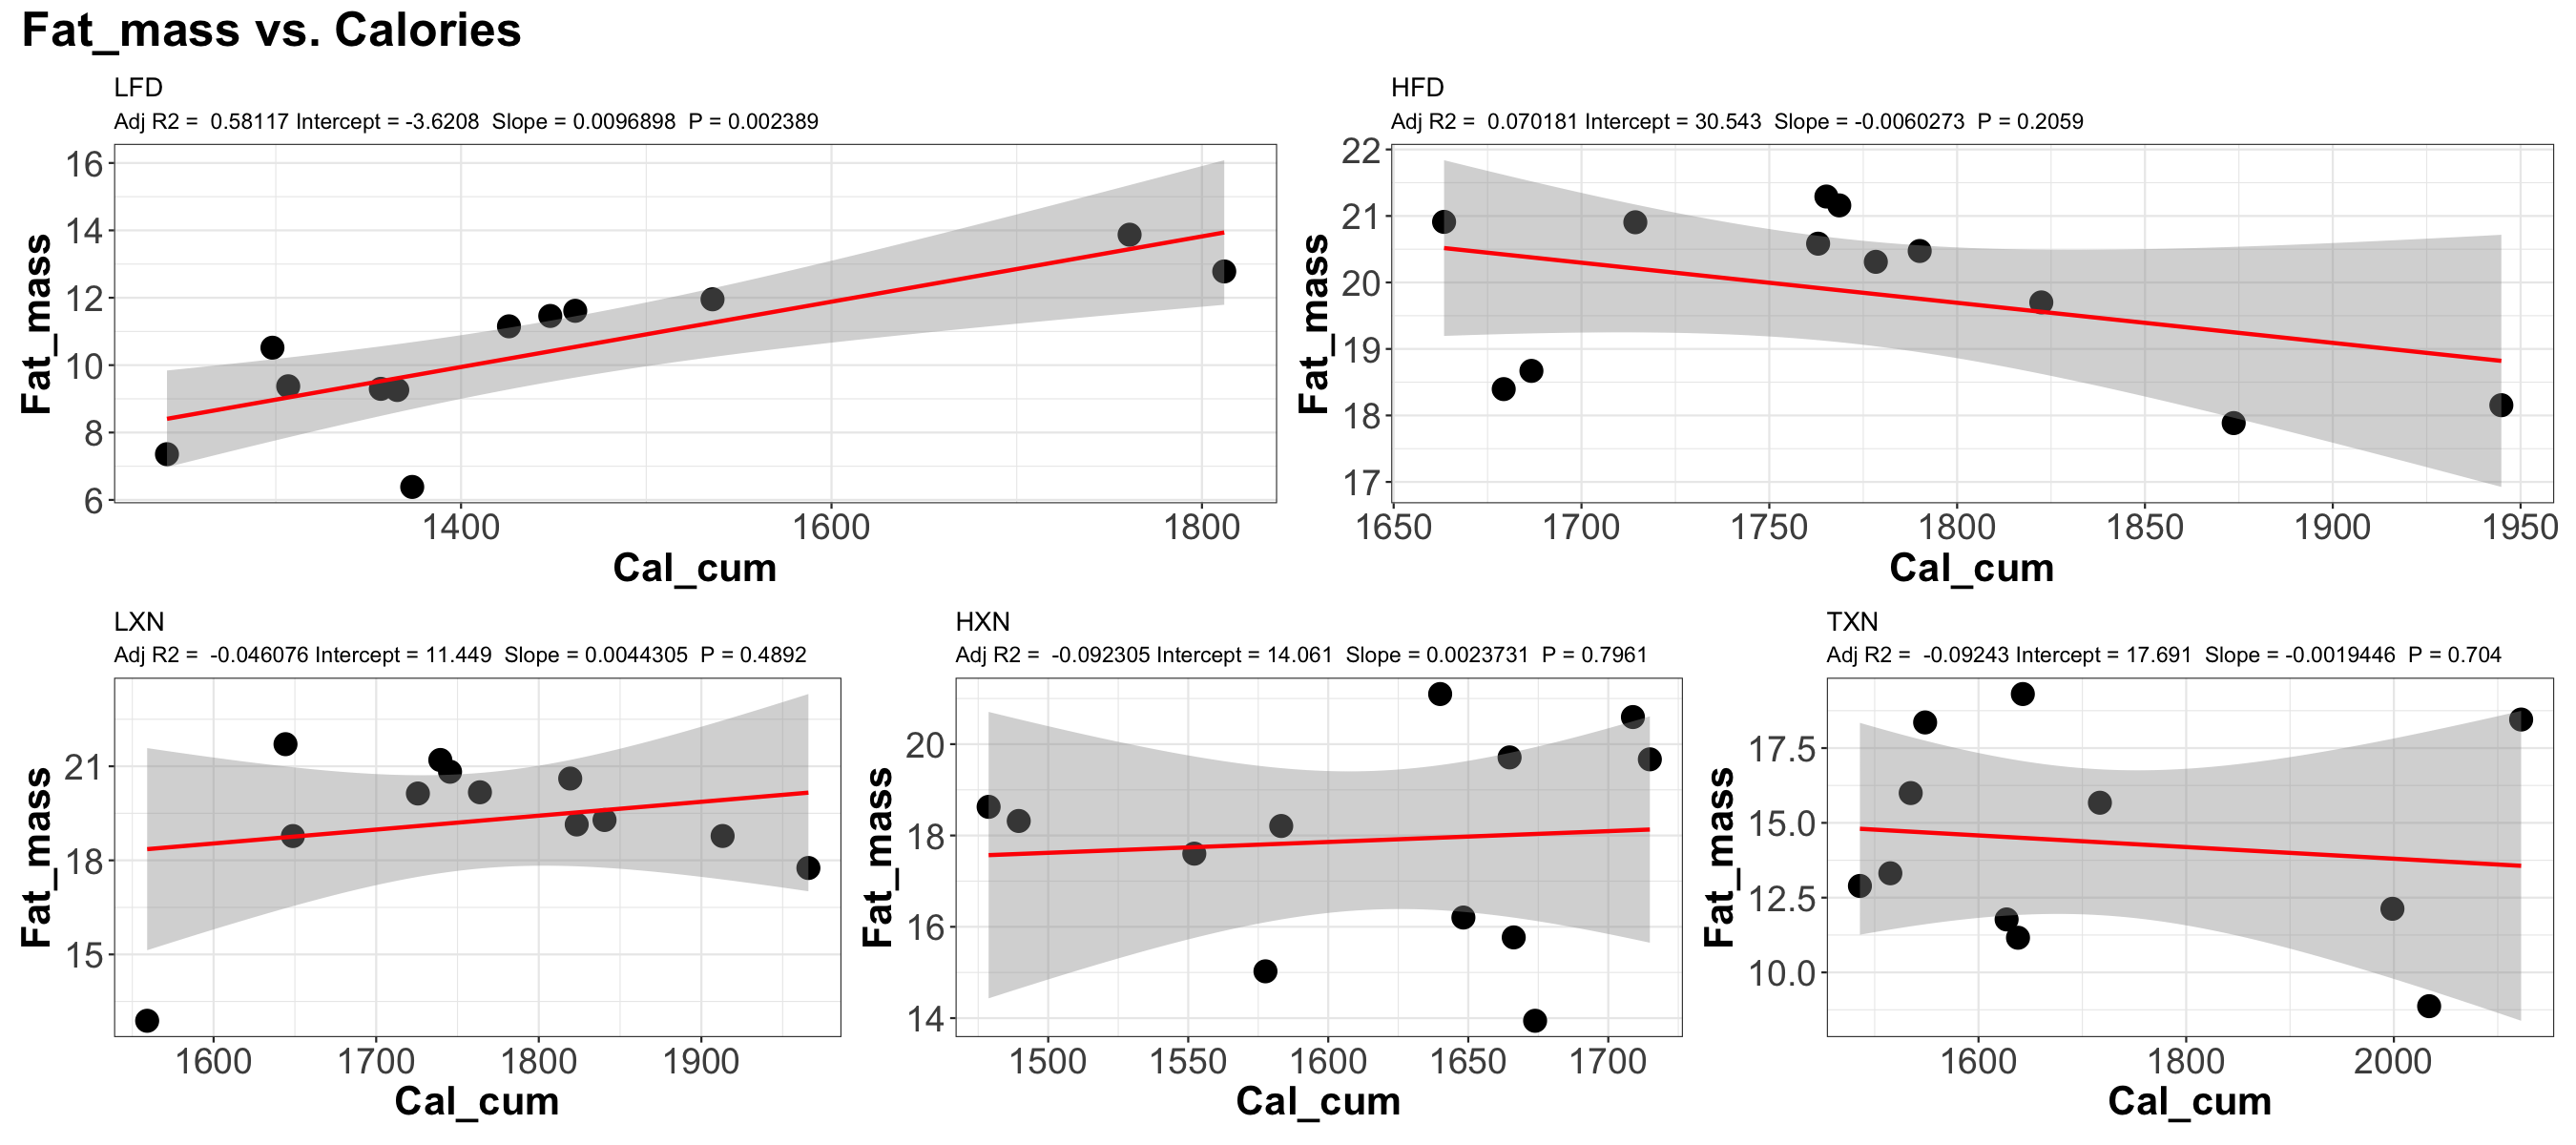

In [90]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_Fat_mass <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_Fat_mass <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_Fat_mass <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_Fat_mass <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_Fat_mass <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_Fat_mass | hfd_Fat_mass) / (lxn_Fat_mass |hxn_Fat_mass | txn_Fat_mass) + 
plot_annotation(title = 'Fat_mass vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

# 5 epididymal fat mass (by scale) and total caloric intake

## 5.1 Correlation

### 5.1.1 overall

#### Spearman

In [83]:
data %>%
    summarise(r = spearman.ci(epi_wat, Cal_cum)$estimate,
             pvalue = cor.test(epi_wat, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(epi_wat, Cal_cum)$conf.int[1],
             upper = spearman.ci(epi_wat, Cal_cum)$conf.int[2])

Warning message in cor.test.default(epi_wat, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


r           pvalue    lower      upper    
1 -0.09431674 0.4773655 -0.3712556 0.2094051

#### Pearson

In [84]:
data %>%
    summarise(r = pearson.ci(epi_wat, Cal_cum)$estimate,
             pvalue = cor.test(epi_wat, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(epi_wat, Cal_cum)$conf.int[1],
             upper = pearson.ci(epi_wat, Cal_cum)$conf.int[2])

r          pvalue    lower      upper    
1 0.02954998 0.8241817 -0.2974127 0.3196638

#### Plot

`geom_smooth()` using formula 'y ~ x'



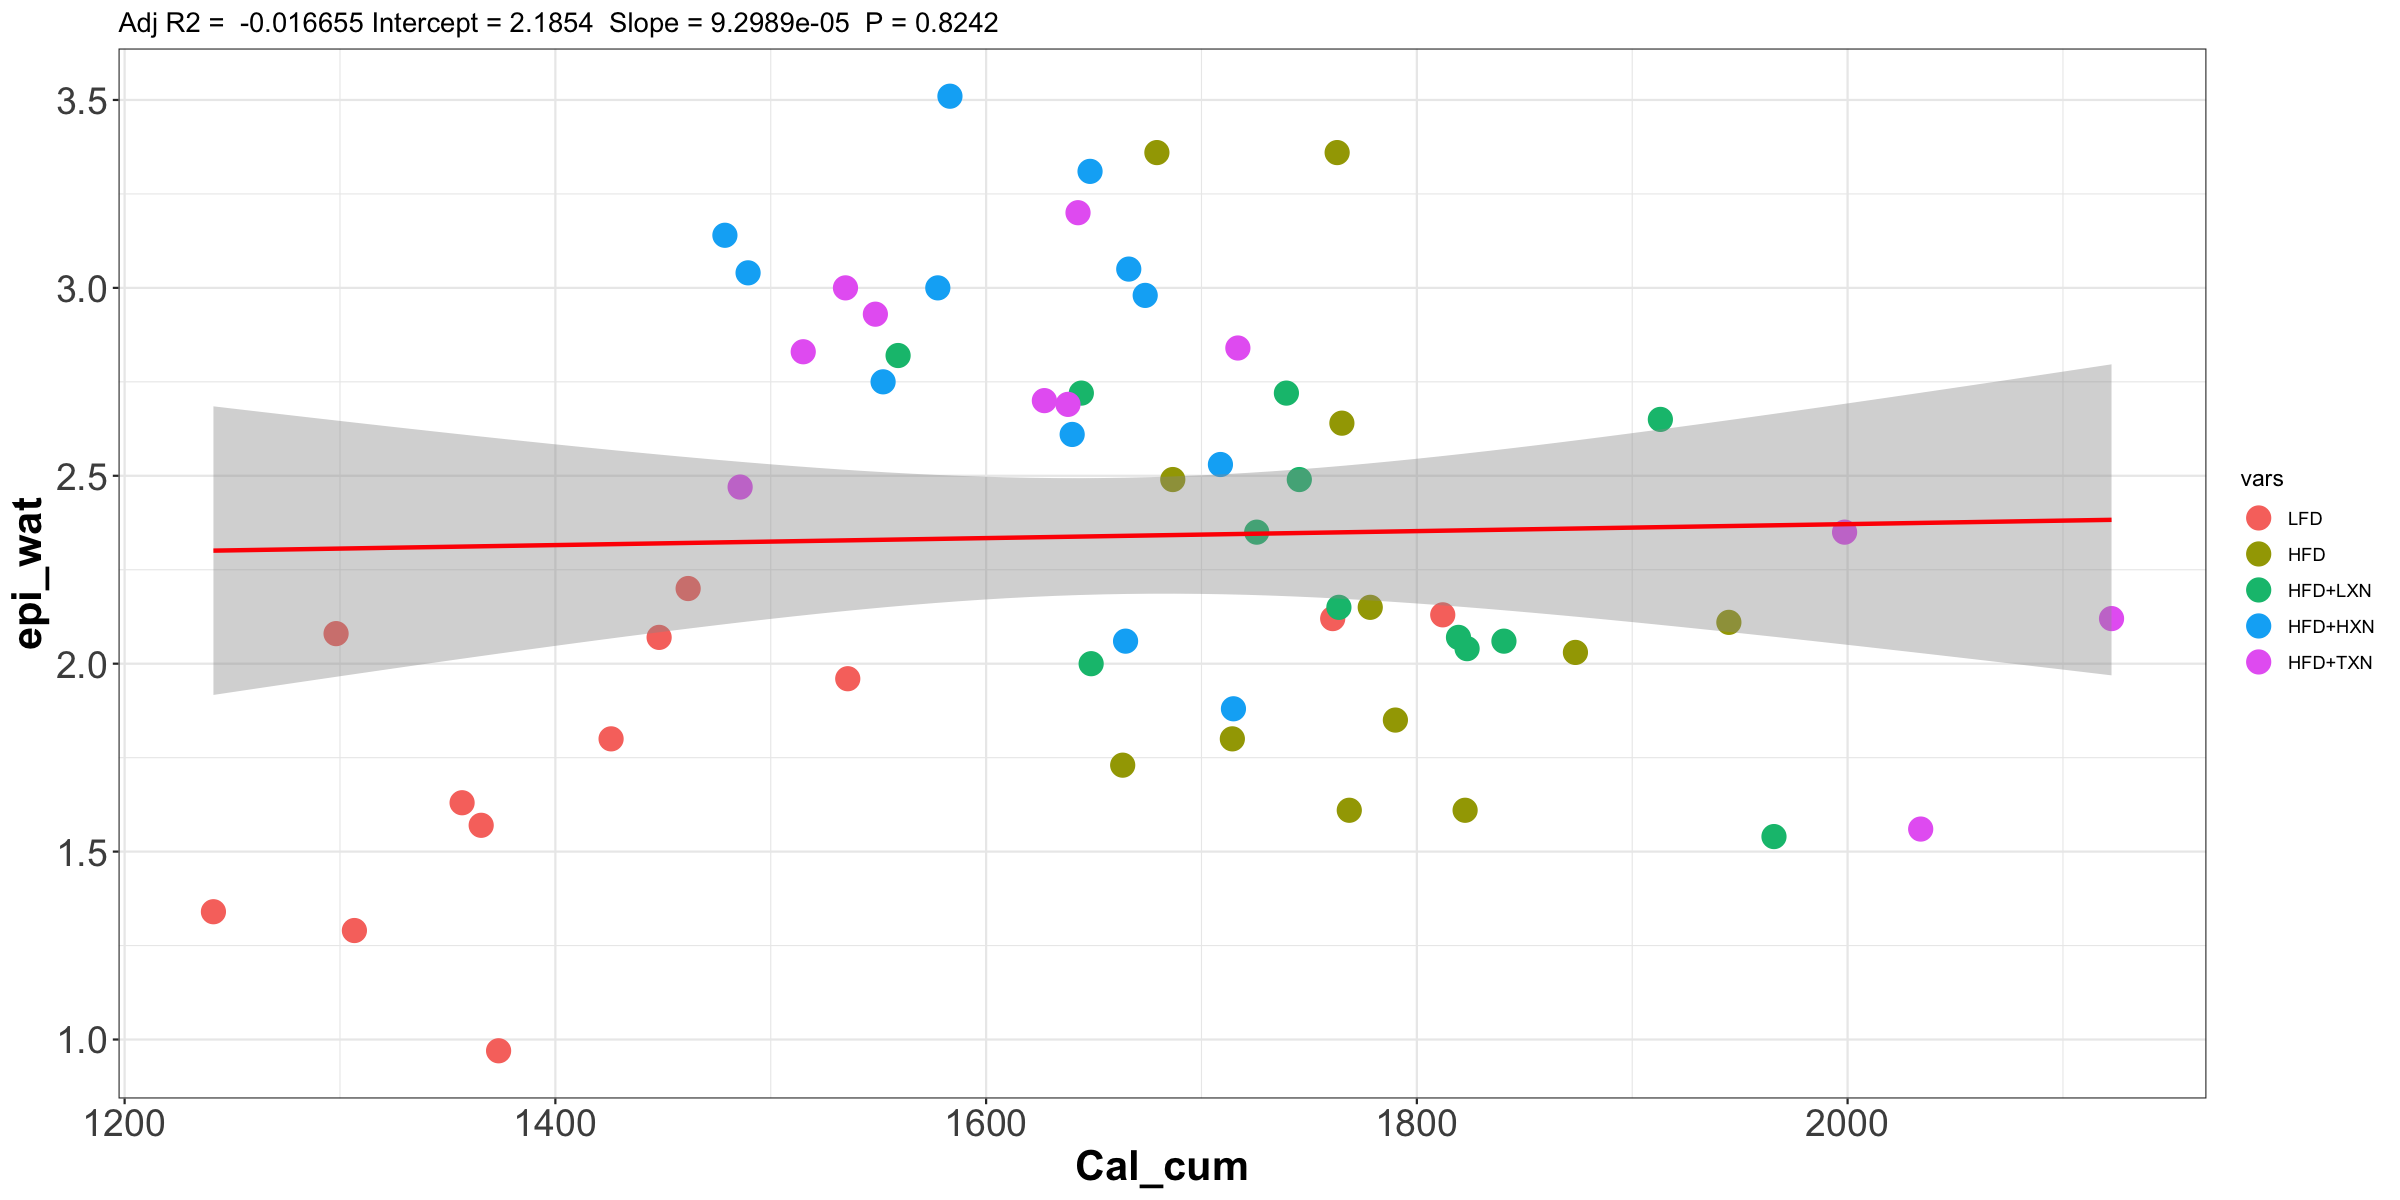

In [85]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)
ggplotRegression(lm(epi_wat ~ Cal_cum, data = data), data$vars)

### 5.1.2 by group

#### Spearman

In [86]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(epi_wat, Cal_cum)$estimate,
             pvalue = cor.test(epi_wat, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(epi_wat, Cal_cum)$conf.int[1],
             upper = spearman.ci(epi_wat, Cal_cum)$conf.int[2])

Warning message in cor.test.default(epi_wat, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(epi_wat, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


vars    r          pvalue     lower      upper     
1 LFD      0.6433566 0.02795455  0.1039427 0.93357934
2 HFD     -0.2526331 0.42824449 -0.7892520 0.42857143
3 HFD+LXN -0.5569185 0.05998361 -0.9870627 0.08303249
4 HFD+HXN -0.5244755 0.08388459 -0.8905109 0.06049822
5 HFD+TXN -0.4727273 0.14560623 -0.8947368 0.37560976

#### Pearson

In [87]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(epi_wat, Cal_cum)$estimate,
             pvalue = cor.test(epi_wat, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(epi_wat, Cal_cum)$conf.int[1],
             upper = pearson.ci(epi_wat, Cal_cum)$conf.int[2])

vars    r          pvalue      lower      upper     
1 LFD      0.5903093 0.043311192  0.3108990  0.8635676
2 HFD     -0.2479814 0.437081674 -0.6716404  0.2177244
3 HFD+LXN -0.5790383 0.048516391 -0.9720065  0.1436258
4 HFD+HXN -0.5245455 0.079971847 -0.7718216 -0.1158193
5 HFD+TXN -0.7571289 0.006971722 -0.9477871  0.2201580

## 5.2 Regression

In [88]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(epi_wat ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope        err          CI.lower      CI.upper      r.squared 
1 LFD      0.001339460 0.0005791873  4.895047e-05  2.629970e-03 0.34846508
2 HFD     -0.001864942 0.0023039045 -6.998361e-03  3.268478e-03 0.06149477
3 HFD+LXN -0.001939055 0.0008633770 -3.862779e-03 -1.533146e-05 0.33528541
4 HFD+HXN -0.003185989 0.0016352564 -6.829567e-03  4.575890e-04 0.27514795
5 HFD+TXN -0.001539081 0.0004426496 -2.540424e-03 -5.377379e-04 0.57324420
  adj.r.squared p.value    
1  0.28331159   0.043311192
2 -0.03235575   0.437081674
3  0.26881395   0.048516391
4  0.20266275   0.079971847
5  0.52582689   0.006971722

#### Plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



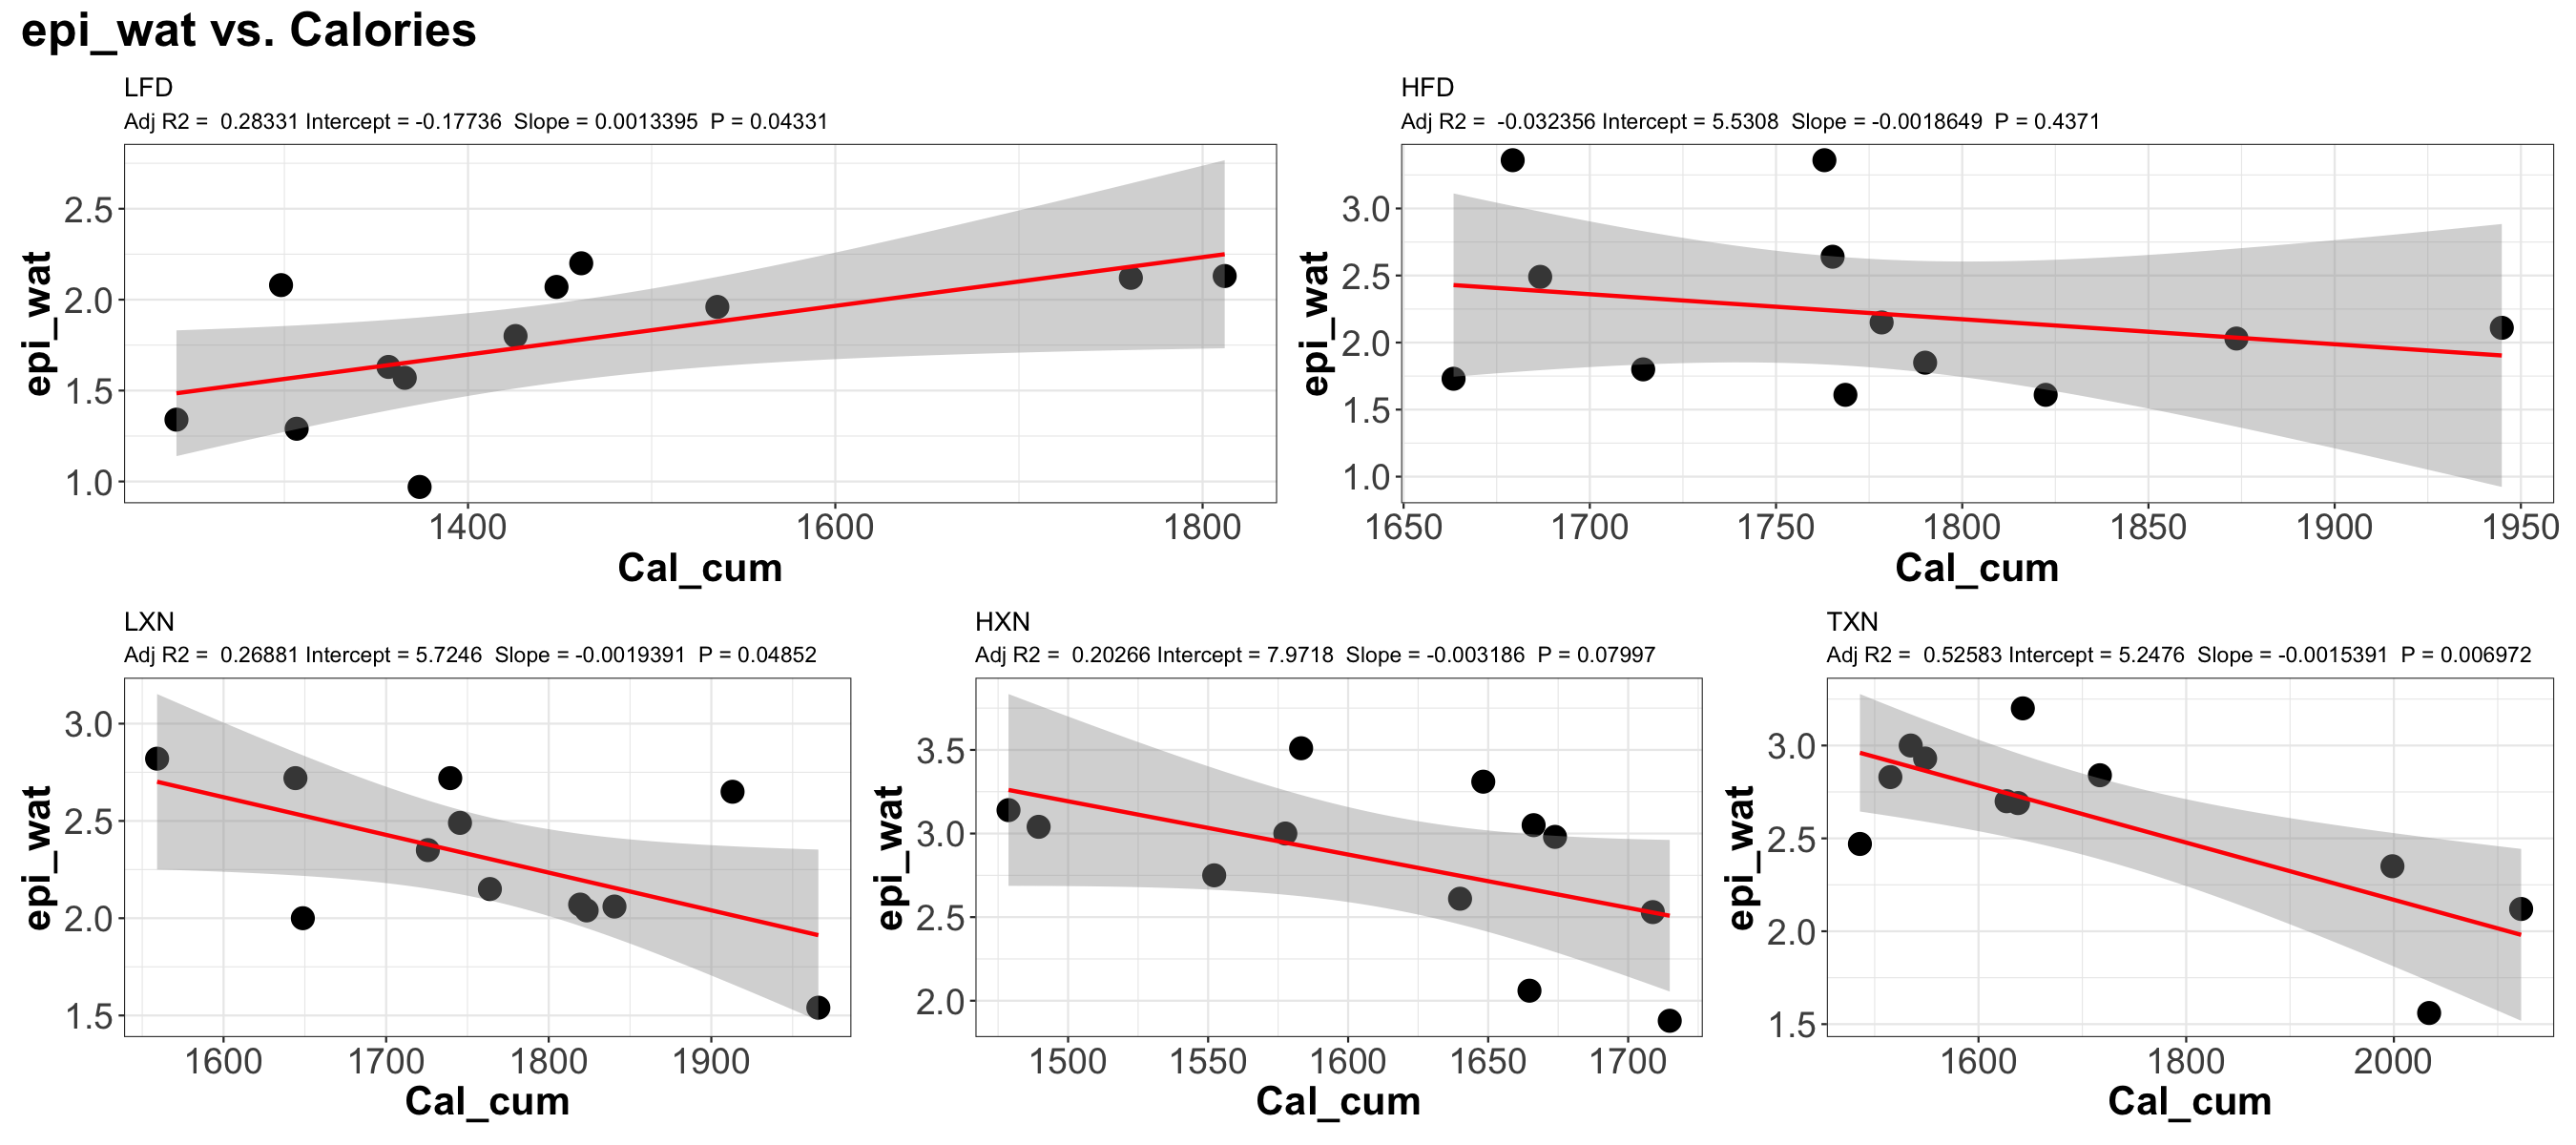

In [89]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_epi_wat <- ggplotRegression2(lm(epi_wat ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_epi_wat <- ggplotRegression2(lm(epi_wat ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_epi_wat <- ggplotRegression2(lm(epi_wat ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_epi_wat <- ggplotRegression2(lm(epi_wat ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_epi_wat <- ggplotRegression2(lm(epi_wat ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_epi_wat | hfd_epi_wat) / (lxn_epi_wat |hxn_epi_wat | txn_epi_wat) + 
plot_annotation(title = 'epi_wat vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

# 6 subq fat mass (by scale) and total caloric intake

## 6.1 Correlation

### 6.1.1 overall

#### Spearman

In [96]:
data %>%
    summarise(r = spearman.ci(subq_wt, Cal_cum)$estimate,
             pvalue = cor.test(subq_wt, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(subq_wt, Cal_cum)$conf.int[1],
             upper = spearman.ci(subq_wt, Cal_cum)$conf.int[2])

Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


r         pvalue       lower     upper    
1 0.4662575 0.0001977014 0.1728981 0.7043593

#### Pearson

In [97]:
data %>%
    summarise(r = pearson.ci(subq_wt, Cal_cum)$estimate,
             pvalue = cor.test(subq_wt, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(subq_wt, Cal_cum)$conf.int[1],
             upper = pearson.ci(subq_wt, Cal_cum)$conf.int[2])

r         pvalue      lower     upper   
1 0.4171008 0.001014633 0.1303286 0.694591

#### Plot

`geom_smooth()` using formula 'y ~ x'



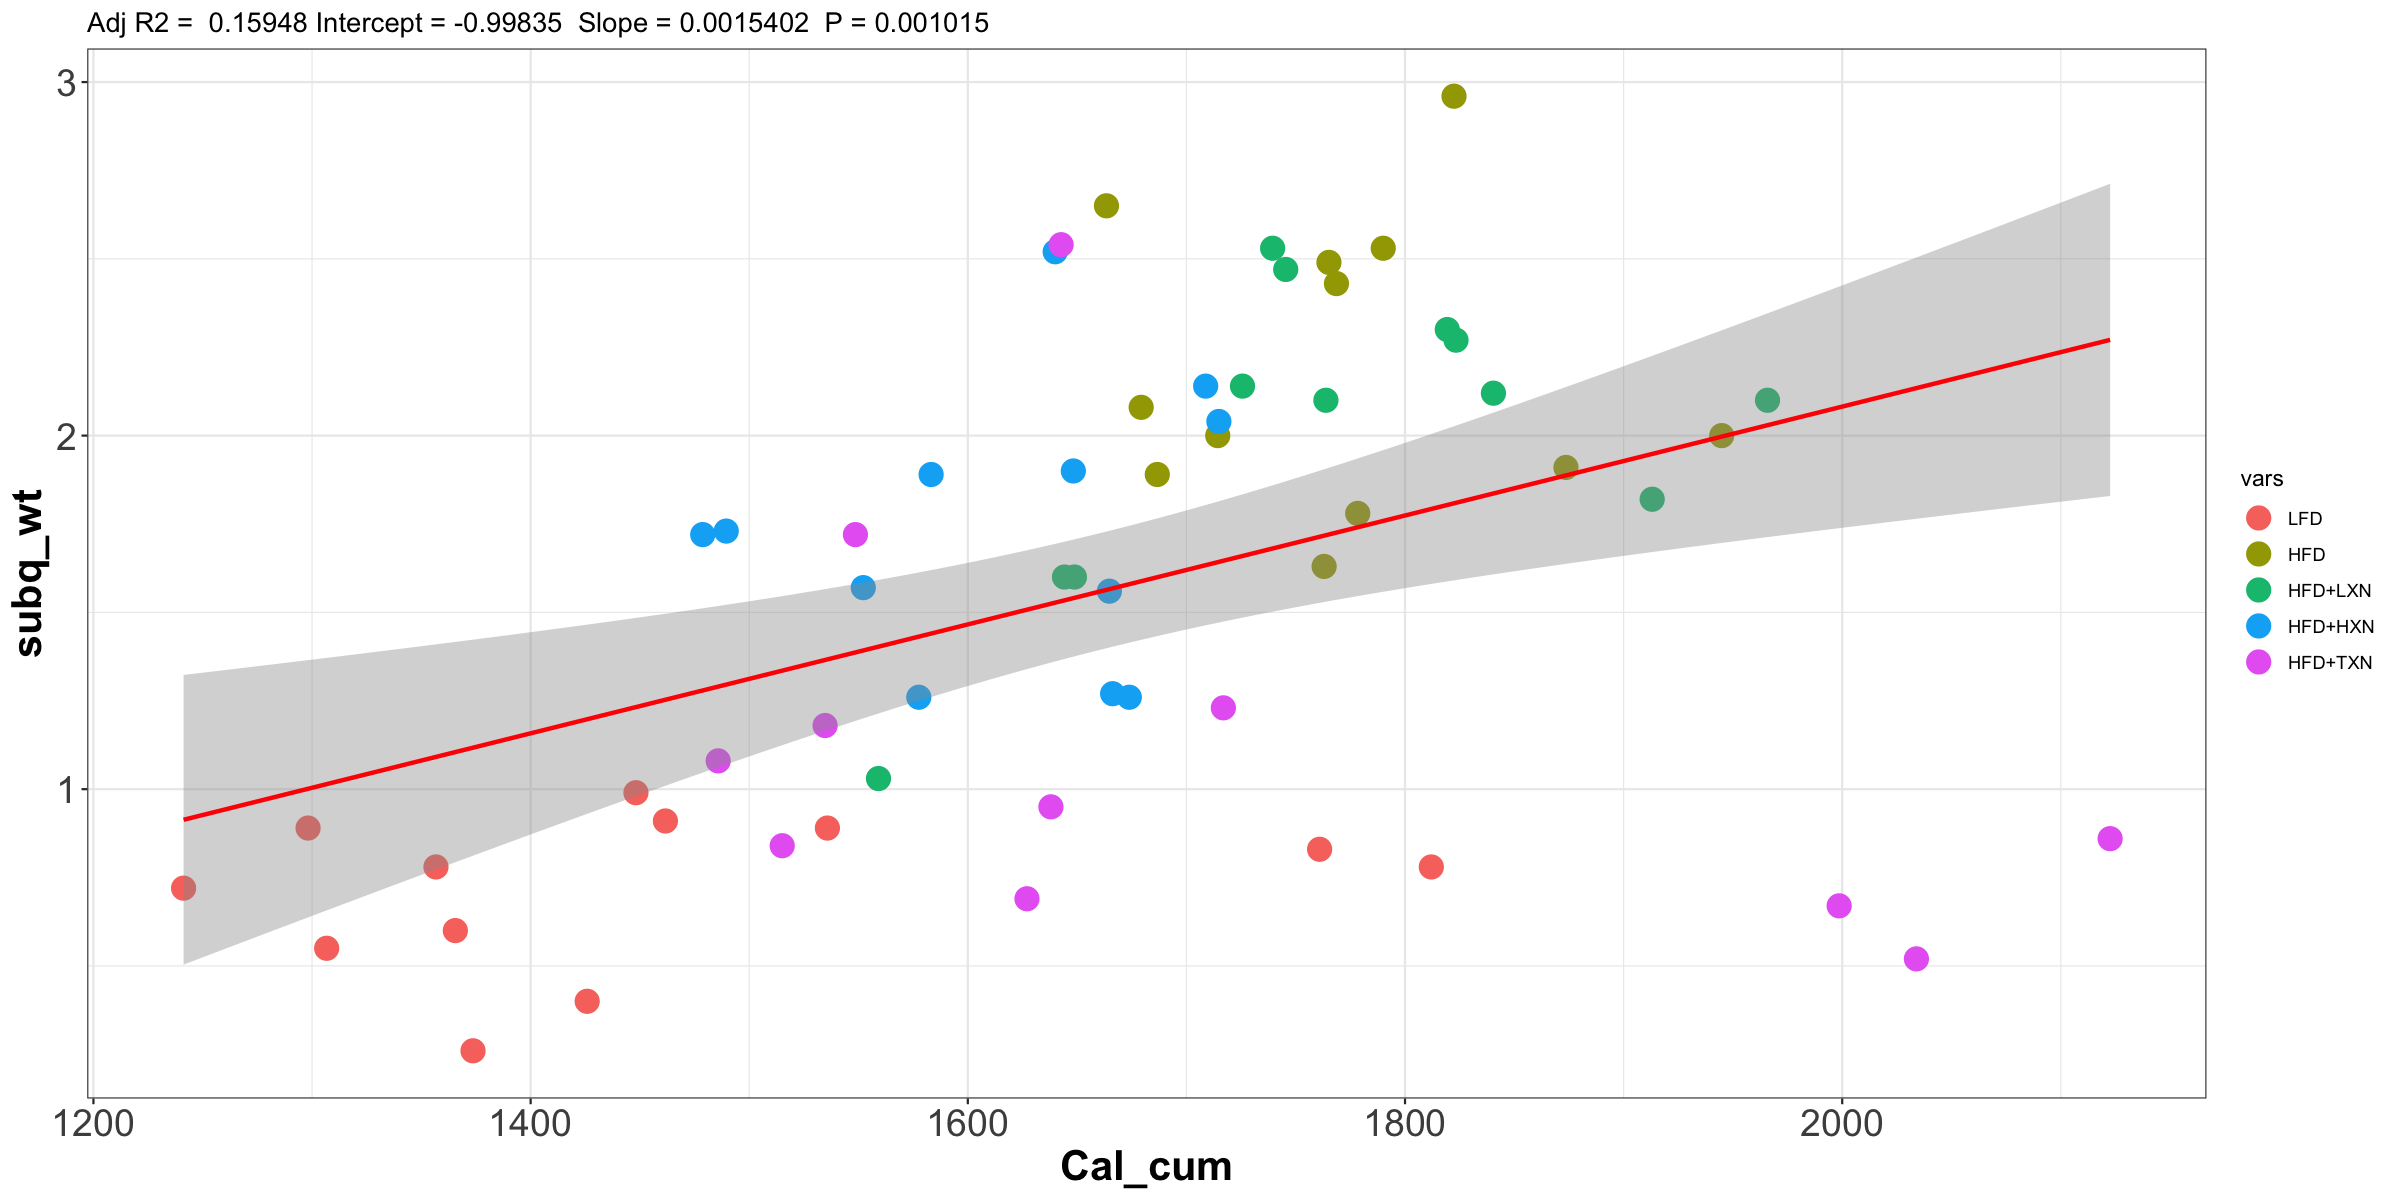

In [93]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)
ggplotRegression(lm(subq_wt ~ Cal_cum, data = data), data$vars)

### 6.1.2 by group

#### Spearman

In [95]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(subq_wt, Cal_cum)$estimate,
             pvalue = cor.test(subq_wt, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(subq_wt, Cal_cum)$conf.int[1],
             upper = spearman.ci(subq_wt, Cal_cum)$conf.int[2])

Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


vars    r          pvalue    lower      upper    
1 LFD      0.3368442 0.2843262 -0.2603983 0.6350365
2 HFD      0.0000000 1.0000000 -0.6296969 0.6175953
3 HFD+LXN  0.3087738 0.3288039 -0.5217391 0.8616991
4 HFD+HXN  0.1681264 0.6014538 -0.5740671 0.6895307
5 HFD+TXN -0.3090909 0.3560399 -0.7757009 0.3567839

#### Pearson

In [98]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(subq_wt, Cal_cum)$estimate,
             pvalue = cor.test(subq_wt, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(subq_wt, Cal_cum)$conf.int[1],
             upper = pearson.ci(subq_wt, Cal_cum)$conf.int[2])

vars    r          pvalue    lower      upper      
1 LFD      0.2729681 0.3906619 -0.0463775  0.57583477
2 HFD     -0.0543666 0.8667331 -0.5238966  0.54296519
3 HFD+LXN  0.5521168 0.0627014 -0.4973331  0.90393273
4 HFD+HXN  0.1735327 0.5896355 -0.3793256  0.59832728
5 HFD+TXN -0.3976367 0.2258691 -0.7822164 -0.02302103

## 6.2 Regression

In [99]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(subq_wt ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope         err          CI.lower      CI.upper     r.squared  
1 LFD      0.0003427162 0.0003819516 -0.0005083249 0.0011937573 0.074511571
2 HFD     -0.0002678418 0.0015556196 -0.0037339782 0.0031982946 0.002955728
3 HFD+LXN  0.0020398611 0.0009741241 -0.0001306226 0.0042103448 0.304832914
4 HFD+HXN  0.0008441713 0.0015149895 -0.0025314357 0.0042197783 0.030113609
5 HFD+TXN -0.0010042506 0.0007724329 -0.0027516152 0.0007431141 0.158114942
  adj.r.squared p.value  
1 -0.01803727   0.3906619
2 -0.09674870   0.8667331
3  0.23531621   0.0627014
4 -0.06687503   0.5896355
5  0.06457216   0.2258691

#### Plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



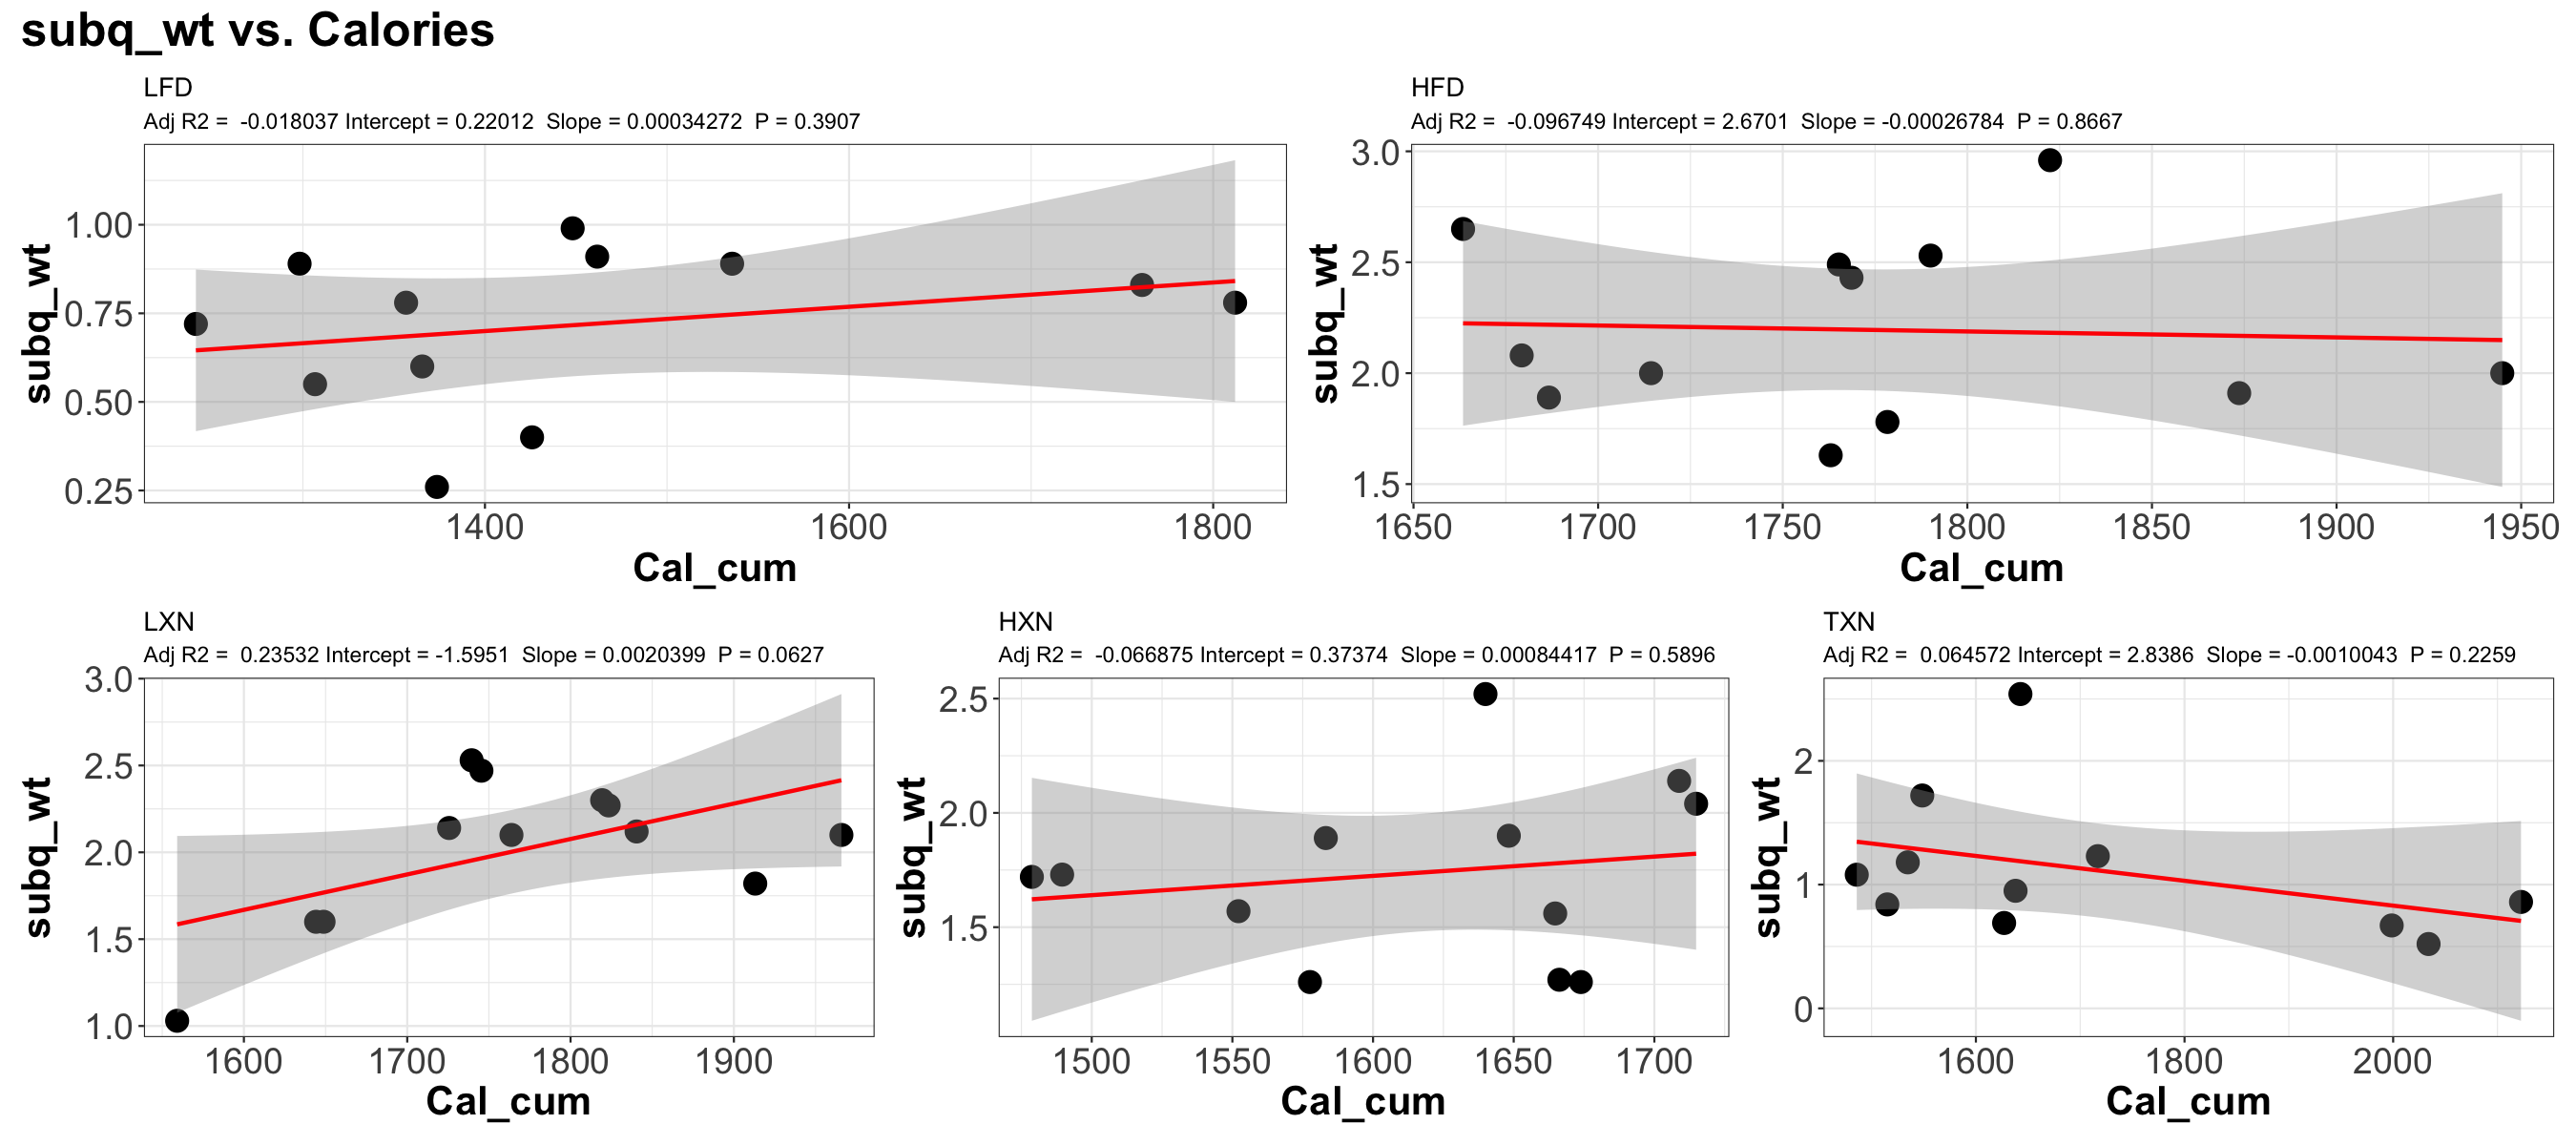

In [100]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_subq_wt <- ggplotRegression2(lm(subq_wt ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_subq_wt <- ggplotRegression2(lm(subq_wt ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_subq_wt <- ggplotRegression2(lm(subq_wt ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_subq_wt <- ggplotRegression2(lm(subq_wt ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_subq_wt <- ggplotRegression2(lm(subq_wt ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_subq_wt | hfd_subq_wt) / (lxn_subq_wt |hxn_subq_wt | txn_subq_wt) + 
plot_annotation(title = 'subq_wt vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

# 7 mesenteric fat mass (by scale) and total caloric intake

## 7.1 Correlation

### 7.1.1 overall

#### Spearman

In [102]:
data %>%
    summarise(r = spearman.ci(mesenteric_wt, Cal_cum)$estimate,
             pvalue = cor.test(mesenteric_wt, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(mesenteric_wt, Cal_cum)$conf.int[1],
             upper = spearman.ci(mesenteric_wt, Cal_cum)$conf.int[2])

Warning message in cor.test.default(mesenteric_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


r         pvalue      lower     upper    
1 0.3977376 0.001811546 0.1307339 0.6246032

#### Pearson

In [103]:
data %>%
    summarise(r = pearson.ci(mesenteric_wt, Cal_cum)$estimate,
             pvalue = cor.test(mesenteric_wt, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(mesenteric_wt, Cal_cum)$conf.int[1],
             upper = pearson.ci(mesenteric_wt, Cal_cum)$conf.int[2])

r         pvalue      lower     upper    
1 0.3877597 0.002410177 0.1601126 0.6115518

#### Plot

`geom_smooth()` using formula 'y ~ x'



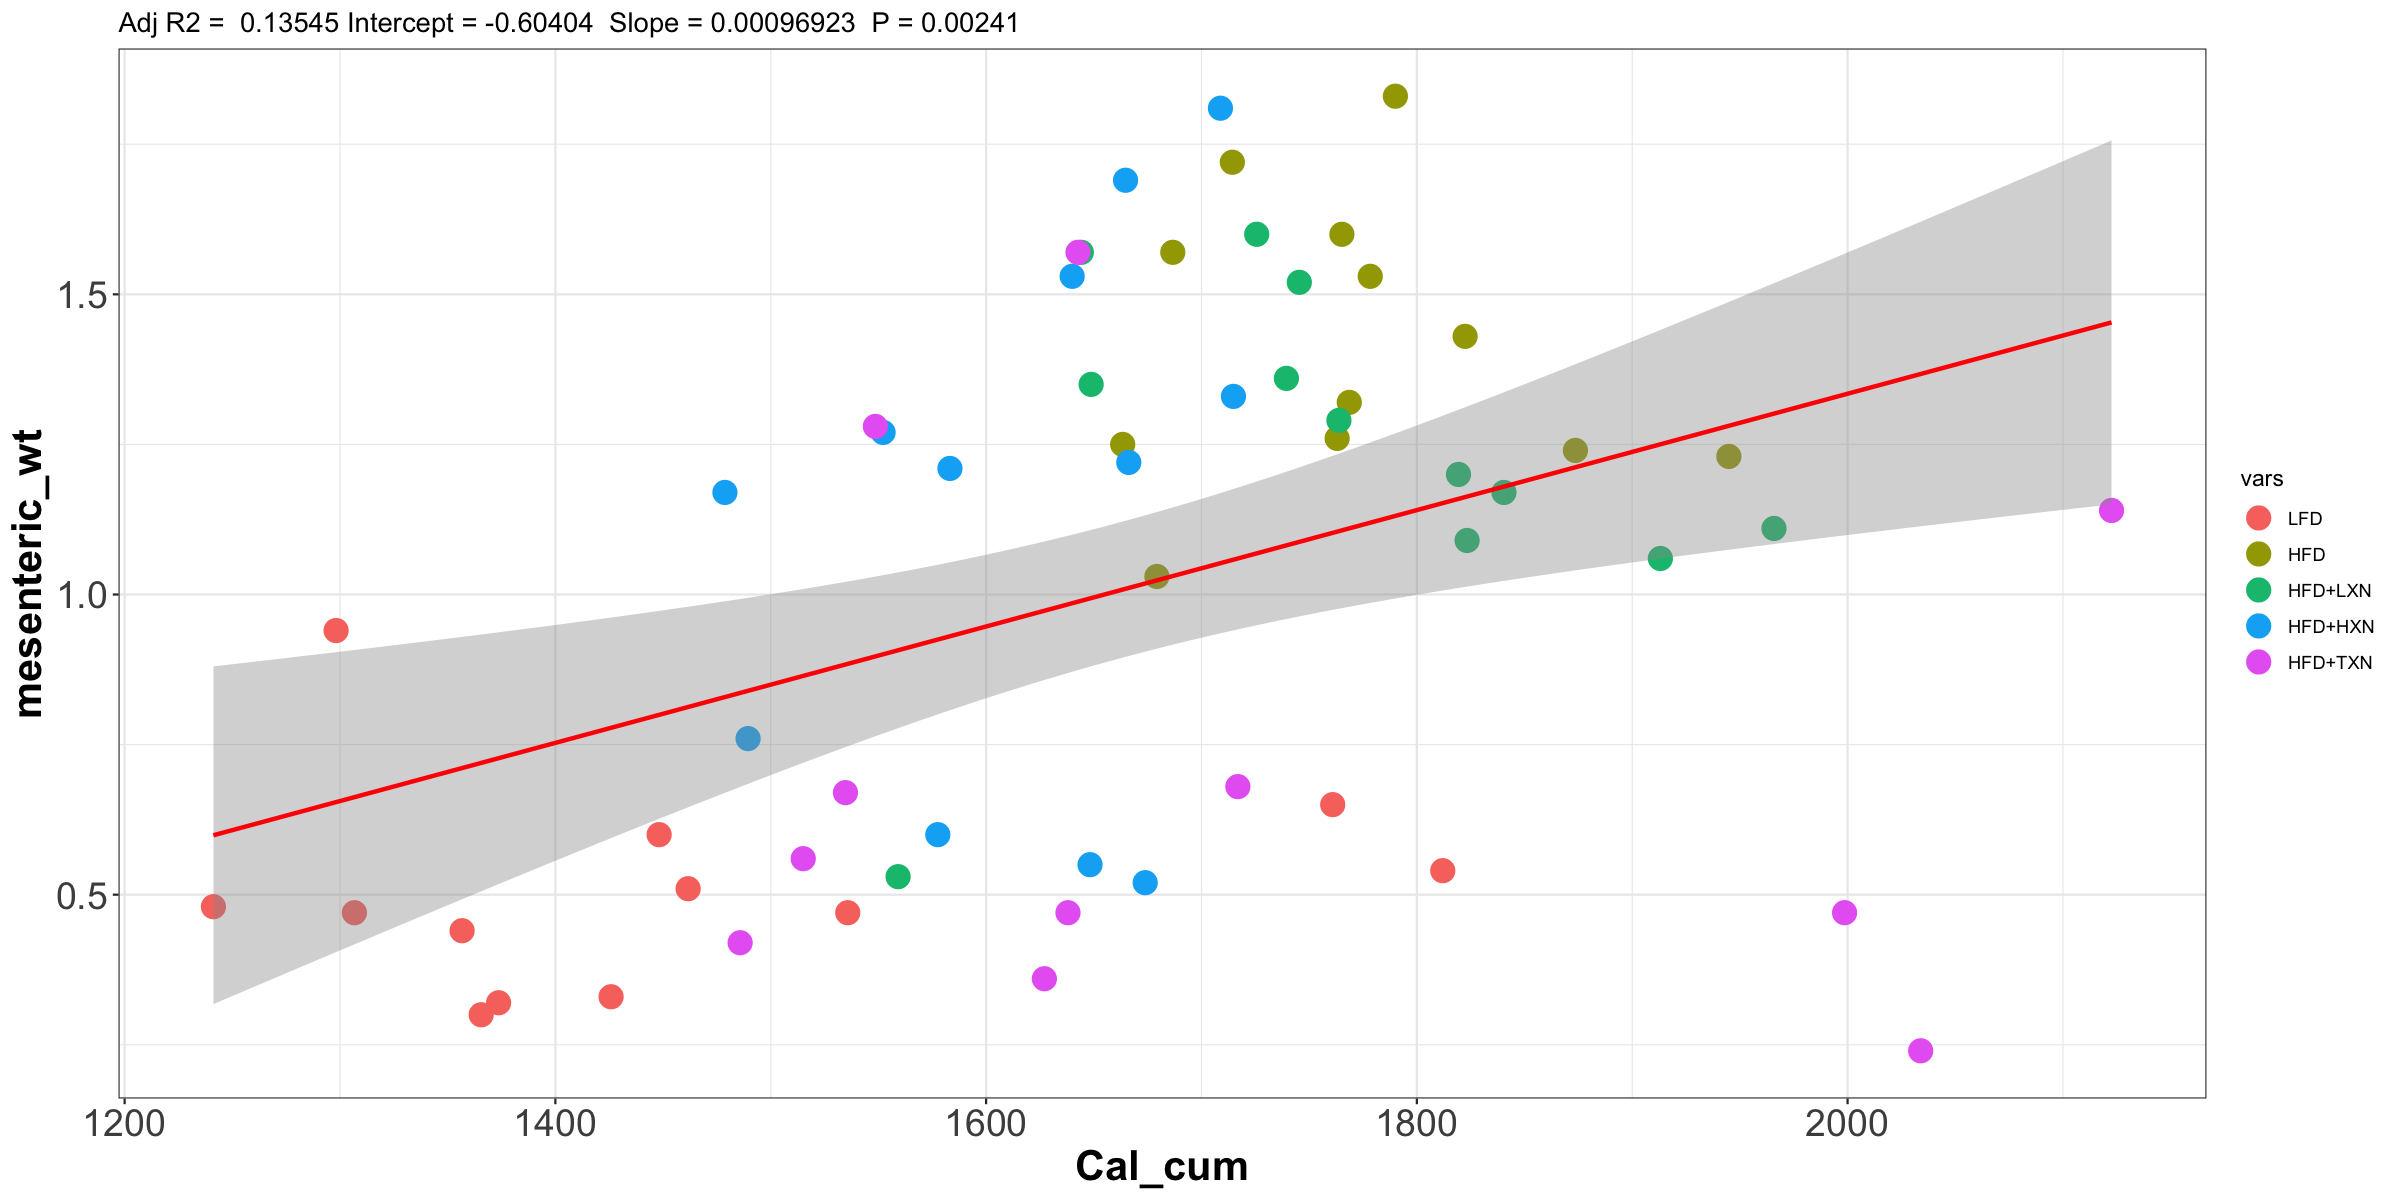

In [104]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)
ggplotRegression(lm(mesenteric_wt ~ Cal_cum, data = data), data$vars)

### 7.1.2 by group

#### Spearman

In [105]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(mesenteric_wt, Cal_cum)$estimate,
             pvalue = cor.test(mesenteric_wt, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(mesenteric_wt, Cal_cum)$conf.int[1],
             upper = spearman.ci(mesenteric_wt, Cal_cum)$conf.int[2])

Warning message in cor.test.default(mesenteric_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(mesenteric_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


vars    r           pvalue    lower      upper    
1 LFD      0.21366057 0.5049127 -0.4703838 0.7428571
2 HFD     -0.02797203 0.9386634 -0.7437722 0.6774194
3 HFD+LXN -0.44055944 0.1542158 -0.9708029 0.2857143
4 HFD+HXN  0.32867133 0.2973851 -0.3406593 0.7883212
5 HFD+TXN  0.06833731 0.8417603 -0.6398104 0.7092377

#### Pearson

In [106]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(mesenteric_wt, Cal_cum)$estimate,
             pvalue = cor.test(mesenteric_wt, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(mesenteric_wt, Cal_cum)$conf.int[1],
             upper = pearson.ci(mesenteric_wt, Cal_cum)$conf.int[2])

vars    r            pvalue    lower      upper    
1 LFD      0.119387105 0.7117082 -0.3797259 0.7578407
2 HFD     -0.082266984 0.7993619 -0.7204687 0.5669457
3 HFD+LXN  0.004874904 0.9880035 -0.9161912 0.6070599
4 HFD+HXN  0.311771565 0.3238830 -0.1872664 0.7656199
5 HFD+TXN -0.048257245 0.8879517 -0.6456722 0.6259685

## 7.2 Regression

In [107]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(mesenteric_wt ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope         err          CI.lower      CI.upper    r.squared   
1 LFD      1.176511e-04 0.0003094008 -0.0005717367 0.000807039 1.425328e-02
2 HFD     -2.358721e-04 0.0009036002 -0.0022492188 0.001777475 6.767857e-03
3 HFD+LXN  1.223506e-05 0.0007936604 -0.0017561505 0.001780621 2.376469e-05
4 HFD+HXN  1.726105e-03 0.0016635131 -0.0019804327 0.005432643 9.720151e-02
5 HFD+TXN -9.021581e-05 0.0006224330 -0.0014982571 0.001317825 2.328762e-03
  adj.r.squared p.value  
1 -0.084321391  0.7117082
2 -0.092555358  0.7993619
3 -0.099973859  0.9880035
4  0.006921659  0.3238830
5 -0.108523598  0.8879517

#### Plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



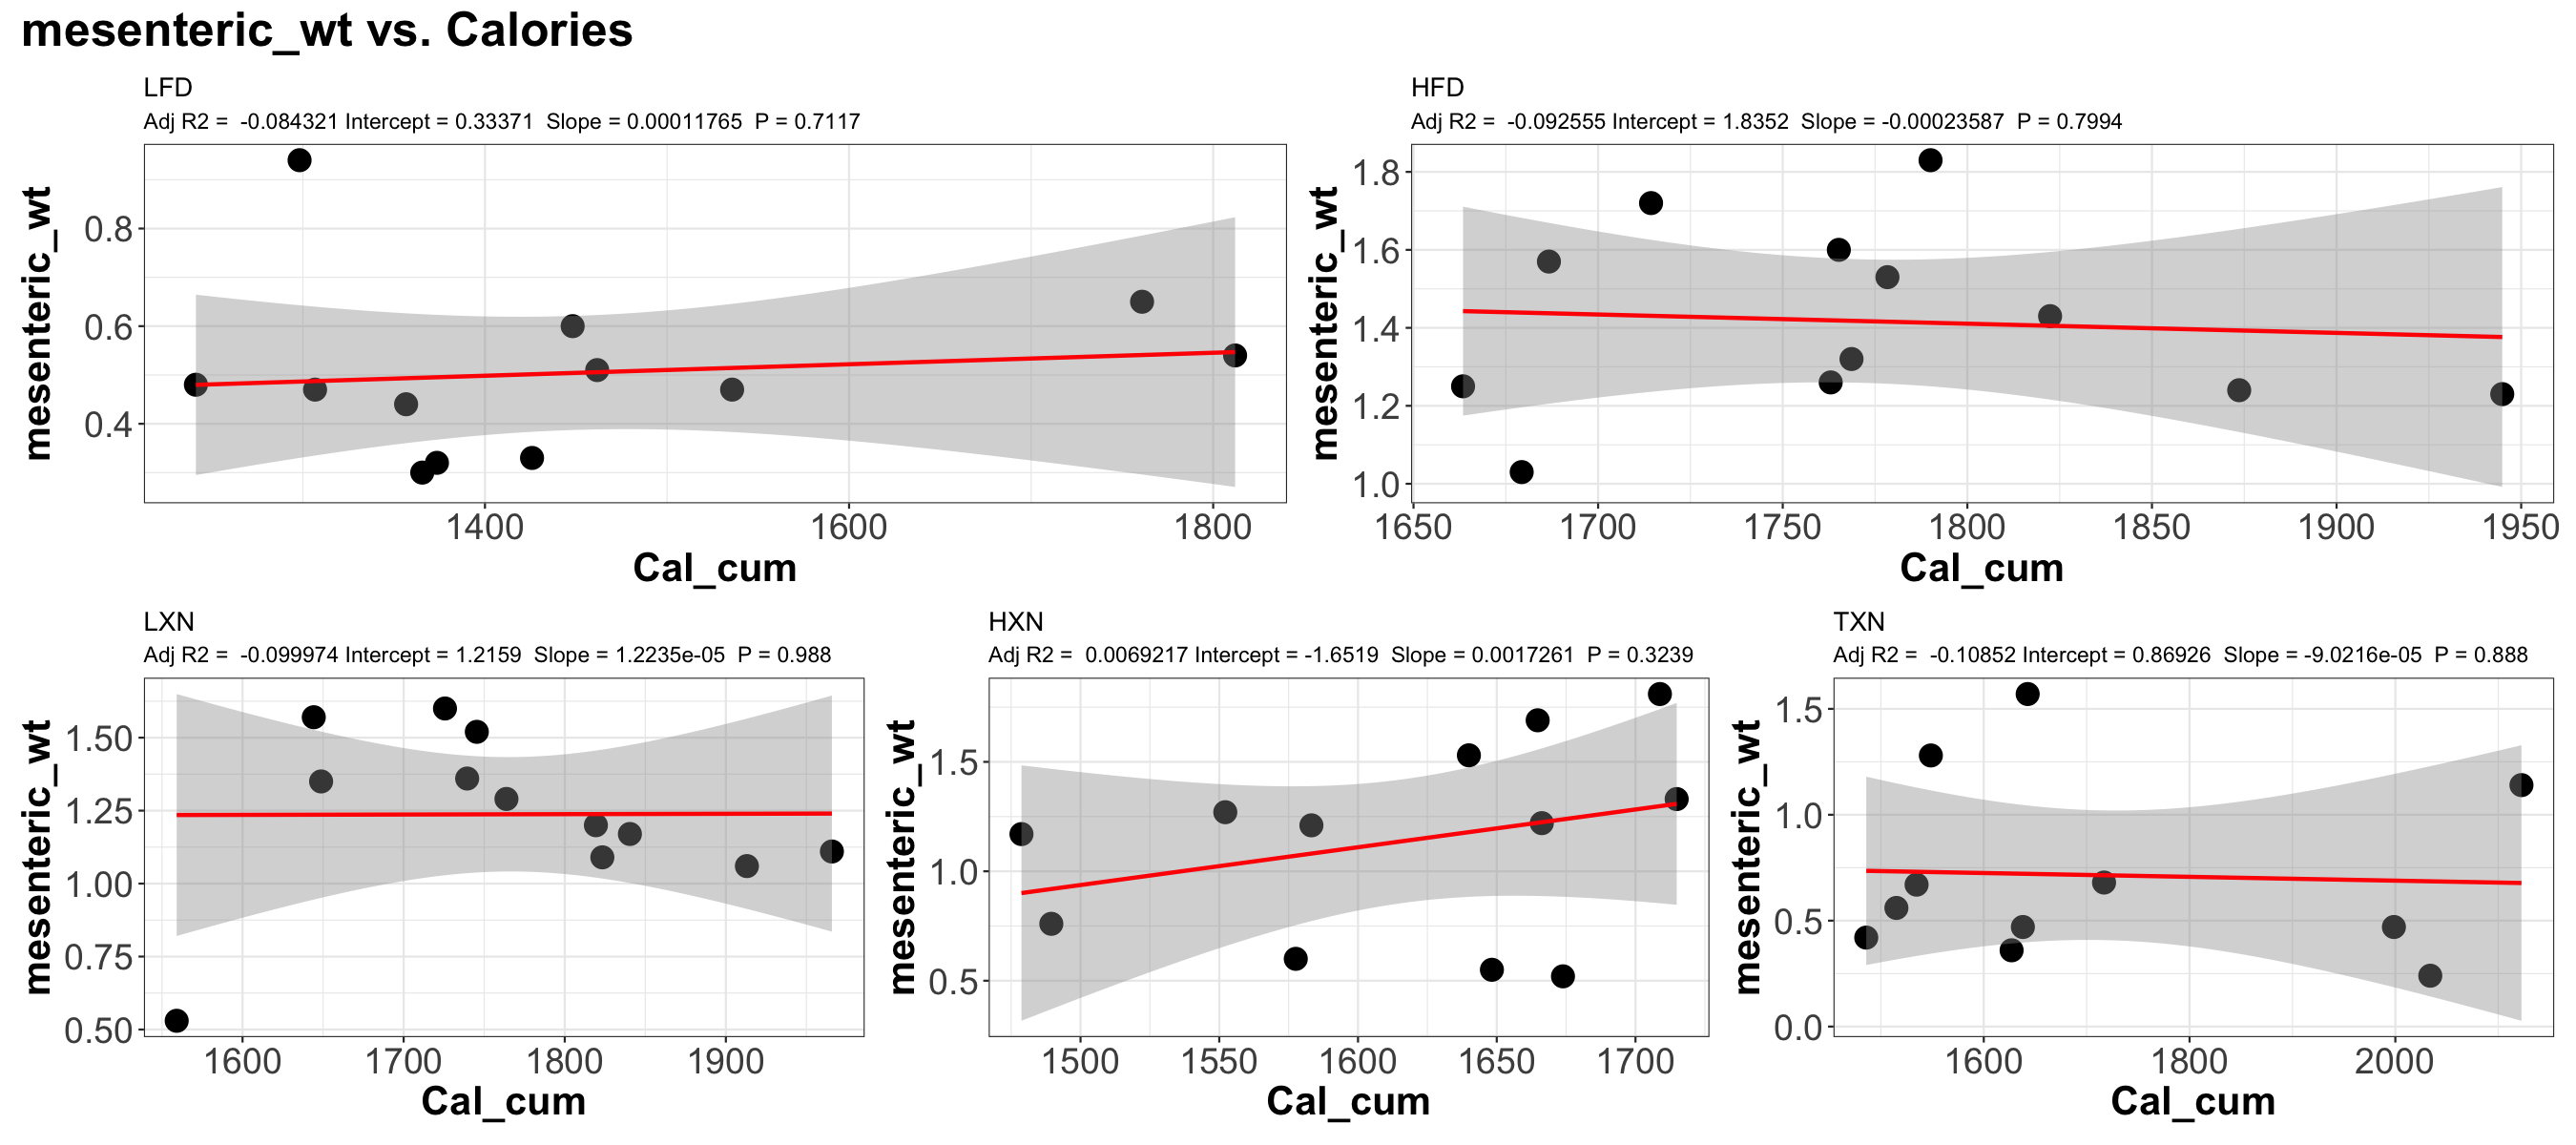

In [108]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_mesenteric_wt <- ggplotRegression2(lm(mesenteric_wt ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_mesenteric_wt <- ggplotRegression2(lm(mesenteric_wt ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_mesenteric_wt <- ggplotRegression2(lm(mesenteric_wt ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_mesenteric_wt <- ggplotRegression2(lm(mesenteric_wt ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_mesenteric_wt <- ggplotRegression2(lm(mesenteric_wt ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_mesenteric_wt | hfd_mesenteric_wt) / (lxn_mesenteric_wt |hxn_mesenteric_wt | txn_mesenteric_wt) + 
plot_annotation(title = 'mesenteric_wt vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

# 8 plasma TAG and total caloric intake

## 8.1 Correlation

### 8.1.1 overall

#### Spearman

In [109]:
data %>%
    summarise(r = spearman.ci(plasma_TAG, Cal_cum)$estimate,
             pvalue = cor.test(plasma_TAG, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(plasma_TAG, Cal_cum)$conf.int[1],
             upper = spearman.ci(plasma_TAG, Cal_cum)$conf.int[2])

r         pvalue    lower      upper     
1 -0.203156 0.1226271 -0.4379716 0.06033752

#### Pearson

In [110]:
data %>%
    summarise(r = pearson.ci(plasma_TAG, Cal_cum)$estimate,
             pvalue = cor.test(plasma_TAG, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(plasma_TAG, Cal_cum)$conf.int[1],
             upper = pearson.ci(plasma_TAG, Cal_cum)$conf.int[2])

r          pvalue    lower      upper    
1 -0.1799993 0.1725075 -0.4138525 0.0456228

#### Plot

`geom_smooth()` using formula 'y ~ x'



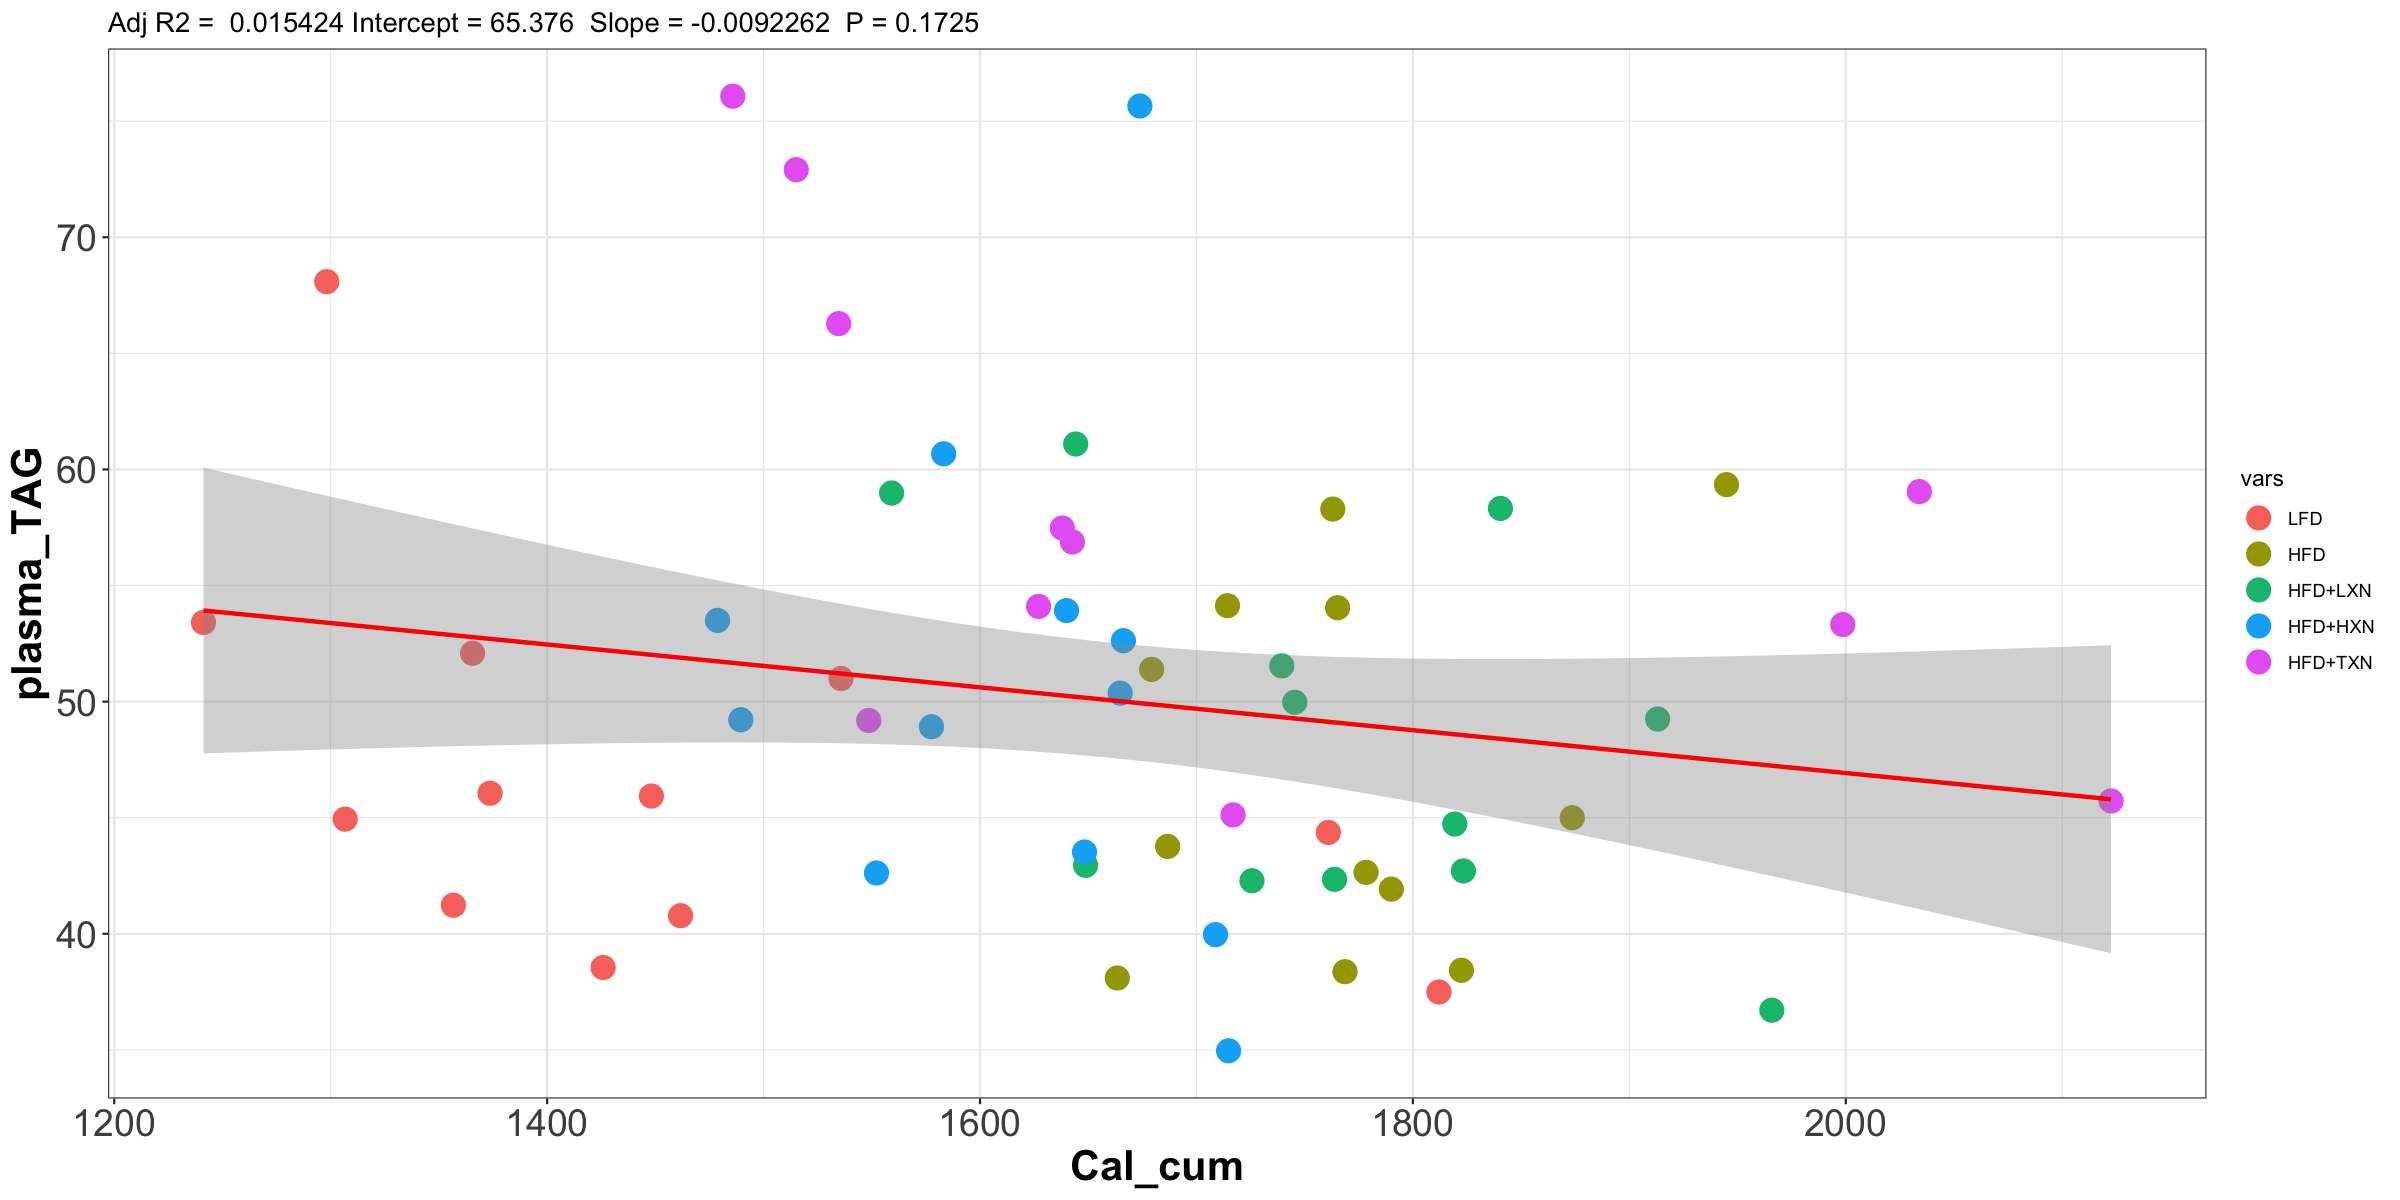

In [111]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)
ggplotRegression(lm(plasma_TAG ~ Cal_cum, data = data), data$vars)

### 8.1.2 by group

#### Spearman

In [112]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(plasma_TAG, Cal_cum)$estimate,
             pvalue = cor.test(plasma_TAG, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(plasma_TAG, Cal_cum)$conf.int[1],
             upper = spearman.ci(plasma_TAG, Cal_cum)$conf.int[2])
## estimated coefficient +- qt(1-alpha/2, df) standard errors

vars    r          pvalue     lower      upper      
1 LFD     -0.6013986 0.04280687 -0.9139785 -0.01098901
2 HFD      0.1258741 0.69971222 -0.6496350  0.69565217
3 HFD+LXN -0.4335664 0.16144643 -0.8636364  0.30656934
4 HFD+HXN -0.2237762 0.48491114 -0.7921147  0.55555556
5 HFD+TXN -0.6454545 0.03700105 -0.9711538  0.08411215

#### Pearson

In [113]:
data %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(plasma_TAG, Cal_cum)$estimate,
             pvalue = cor.test(plasma_TAG, Cal_cum, method = "pearson")$p.value,
             lower = pearson.ci(plasma_TAG, Cal_cum)$conf.int[1],
             upper = pearson.ci(plasma_TAG, Cal_cum)$conf.int[2])

vars    r          pvalue     lower      upper      
1 LFD     -0.4802956 0.11401399 -0.7684707 -0.06565902
2 HFD      0.2362468 0.45976040 -0.5613826  0.68415449
3 HFD+LXN -0.4975281 0.09979209 -0.8811004  0.24248349
4 HFD+HXN -0.1210258 0.70790360 -0.7180138  0.49269978
5 HFD+TXN -0.5436265 0.08389369 -0.8793610 -0.01448747

## 8.2 Regression

In [114]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(plasma_TAG ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (slope + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (slope + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars    slope       err        CI.lower    CI.upper    r.squared 
1 LFD     -0.02277021 0.01314955 -0.05206922 0.006528809 0.23068387
2 HFD      0.02271031 0.02953836 -0.04310525 0.088525870 0.05581253
3 HFD+LXN -0.03357288 0.01851034 -0.07481649 0.007670726 0.24753420
4 HFD+HXN -0.01606718 0.04167327 -0.10892100 0.076786645 0.01464724
5 HFD+TXN -0.02444727 0.01258171 -0.05290908 0.004014544 0.29552978
  adj.r.squared p.value   
1  0.15375226   0.11401399
2 -0.03860622   0.45976040
3  0.17228762   0.09979209
4 -0.08388803   0.70790360
5  0.21725531   0.08389369

#### Plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



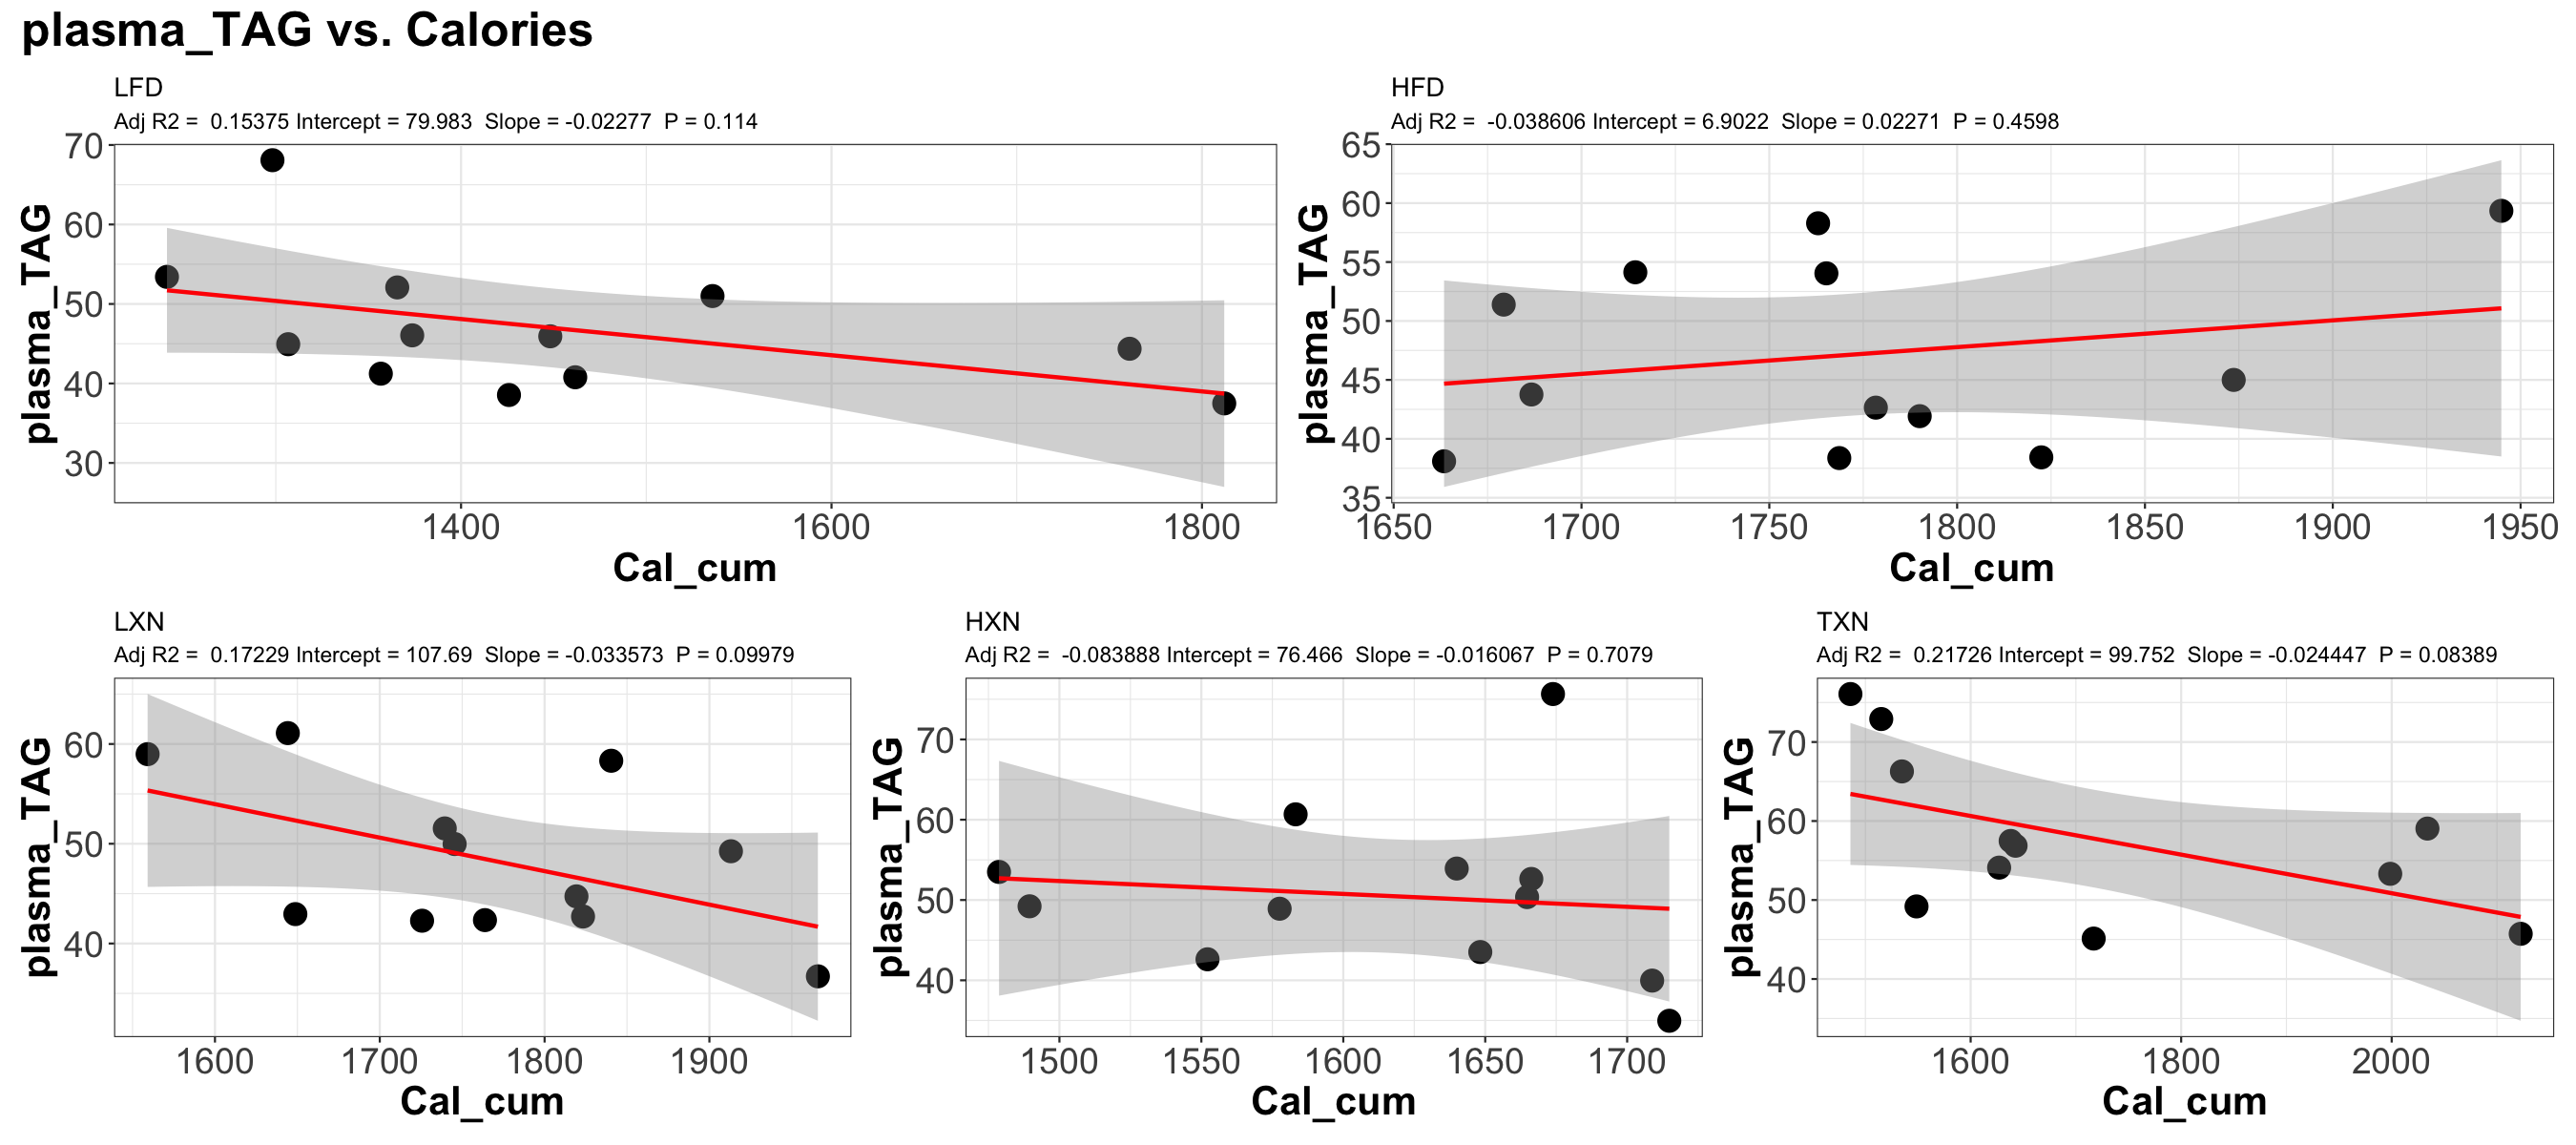

In [115]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_plasma_TAG <- ggplotRegression2(lm(plasma_TAG ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_plasma_TAG <- ggplotRegression2(lm(plasma_TAG ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_plasma_TAG <- ggplotRegression2(lm(plasma_TAG ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_plasma_TAG <- ggplotRegression2(lm(plasma_TAG ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_plasma_TAG <- ggplotRegression2(lm(plasma_TAG ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_plasma_TAG | hfd_plasma_TAG) / (lxn_plasma_TAG |hxn_plasma_TAG | txn_plasma_TAG) + 
plot_annotation(title = 'plasma_TAG vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))